In [2]:
#load in the libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, plot_partial_dependence
from matplotlib.pyplot import figure
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from statistics import mean
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from nested_cv import NestedCV
from IPython.display import Image
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns
from xgboost.sklearn import XGBRegressor
from sklearn.inspection import PartialDependenceDisplay
import pickle

In [3]:
#make function to match the status for what ever parasite it is, binarize it, and drop unnecessary columns
def gettrain(df, parasite):
    #matching the sandfly status for the species of parasite to the sandfly in the larger dataframe
    for j in range(len(df)):
        for i in range(len(status)):
            if df.loc[j, 'species'] == status.loc[i, 'species']:
                df.loc[j, parasite] = status.loc[i, parasite]
    #fill the remaining vector status column with 0s, then binarize the status
    df[parasite] = df[parasite].fillna(0).map(lambda x : x//2)
    #set the index as the species name
    train = df.set_index('species')
    #drop unnecessary columns
    train = train.drop(columns=['Unnamed: 0', '.imp', '.id'])
    if 'index' in df.columns:
        train = train.drop(columns=['index'])
    
    return train

In [4]:
#code taken from https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d
#use the bootstrap methos to make make a confidence interval
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

# print the averages and the confidence interval
def getconf_interval(data):
    # Draw 15000 bootstrap replicates
    bs_replicates_aucs = draw_bs_replicates(data,np.mean,15000)

    # Print empirical mean
    print("Empirical mean: " + str(round(np.mean(data), 3)))

    # Print the mean of bootstrap replicates
    print("Bootstrap replicates mean: " + str(round(np.mean(bs_replicates_aucs), 3)))

    # Get the corresponding values of 2.5th and 97.5th percentiles
    conf_interval = np.percentile(bs_replicates_aucs,[2.5,97.5])

    # Print the interval
    print("The confidence interval: ", np.round(conf_interval, 3))


# return the confidence interval
def getconf_interval_var(data):
    # Draw 15000 bootstrap replicates
    bs_replicates_aucs = draw_bs_replicates(data,np.mean,15000)

    # Get the corresponding values of 2.5th and 97.5th percentiles
    conf_interval = np.percentile(bs_replicates_aucs,[2.5,97.5])
    
    return conf_interval

#get imp100, a dataframe of the variable importances across the ten models
def fscore(list_of_models):
    #takes in modelslist created in the predtable function
    #make a list of the most important variables for each model
    importancelist = []
    for x in range(100):
        importancelist.append(pd.DataFrame(list_of_models[x].get_booster().get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False))

    #make a dataframe of all the dataframes in importancelist
    imp100 = pd.DataFrame()
    for i in range(100):
        imp100 = imp100.append(importancelist[i], ignore_index = True)
                
    return imp100

#takes in modelslist created in the predtable function
def var_impt(list_of_models):

    #add the importances of each feature and arrange them in decreasing order
    mean = fscore(list_of_models).groupby('feature').mean().sort_values(by='importance', ascending=False).reset_index()
    std = fscore(list_of_models).groupby('feature').std().sort_values(by='importance', ascending=False).reset_index()
    count = pd.DataFrame(fscore(list_of_models)['feature'].value_counts()).reset_index()

    #get std into dataframes
    for x in range(len(mean)):
        for y in range(len(std)):
            if mean.loc[x, 'feature'] == std.loc[y, 'feature']:
                mean.loc[x, 'std'] = std.loc[y, 'importance']
        #get count of variables
        for z in range(len(count)):
            if mean.loc[x, 'feature'] == count.loc[z, 'index']:
                mean.loc[x, 'count'] = count.loc[z, 'feature'] 
                
    return mean.round(3)

# proven

In [5]:
def getstatus(df, parasite):
    for i in range(len(status)):
        for j in range(len(df)):
            if status.loc[i, 'species'] == df.loc[j, 'species']:
                df.loc[j, 'potential/proven'] = status.loc[i, parasite]
    df = df.fillna(0)
    return df

### clean the original dataset

In [6]:
original = pd.read_csv('final2/one hot encoded original data.csv')
original = original.drop(columns=['Argentina', 'Belize','Bolivia', 'Brazil', 'Canada', 'CaymanIslands', 'Chile', 'Colombia', 'Costa.Rica', 'Cuba', 'Dominican.Republic', 'Ecuador', 'El.Salvador', 'French.Guiana','Guadeloupe', 'Guatemala', 'Grenada', 'Guyana', 'Haiti', 'Honduras', 'Jamaica','Martinica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay','PuertoRico', 'Peru', 'Suriname', 'TrinidadTobago', 'Uruguay', 'USA', 'Venezuela','VirginIslands'])
status = pd.read_csv('final2/sandfly status.csv')
#if sandfly is a proven vector for any species of leish, mark it in a new column 'cl' as 1
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 1

#get cleaned train datasets in a list
parasite = 'leish'
for j in range(len(original)):
    for i in range(len(status)):
        if original.loc[j, 'species'] == status.loc[i, 'species']:
            original.loc[j, parasite] = status.loc[i, parasite]

#fill the remaining vector status column with 0s, then binarize the status
original[parasite] = original[parasite].fillna(0).map(lambda x : x//2)
#set the index as the species name
original = original.set_index('species')
#drop unnecessary columns
original_clean = original.drop(columns=['Unnamed: 0'])

####LOOK AT CORRELLATED VARIABLES??
#tribe_Hertigiini is corr w 'genus_Warileya'
#subtribe_hertigiina is corr w 'genus_Warileya'
#peri is corr w semi.domestic
#'genus_Brumptomyia' is corr w 'subtribe_Brumptomyiina'
#'genus_Micropygomyia' is corr w 'subtribe_Sergentomyiina'

#wing_width / hs.canopy
#wing_width / hs.floor
#labruml_wingl / log.labrum.length
#log.grass.cover / log.shrub.cover
#domestic / intra
#temp / wing.width
#log.elevation / temp
#log.temp.var / temp.range
#maxshape_sabre / genus_Brumptomyia
#log.dental.depth / log.labrum.length


# pd.DataFrame(original_clean.corr()).to_csv('correllation.csv')
original_clean = original_clean.drop(columns=['subtribe_Sergentomyiina', 'subtribe_Brumptomyiina',
                                              'peri', 'subtribe_Hertigiina', 'tribe_Hertigiini',
                                              'wing.width', 'labruml_wingl', 'log.shrub.cover',
                                              'intra', 'log.elevation', 'log.temp.var', 'maxshape_sabre', 'log.dental.depth'])

# citation prediction - xgbregressor

In [724]:
#if the model performs super bad, then no need to do a w/o citations analysis

In [18]:
data_c = original_clean.iloc[:,:-1].drop(columns = ['log.citations'])
c = original_clean.iloc[:,:-1]['log.citations']
data_c['log.citations'] = c

In [261]:
data_c.to_csv('final2/citation data.csv')

In [21]:
#####code taken from https://www.kaggle.com/felipefiorini/xgboost-hyper-parameter-tuning



def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.02, 0.04, 0.06, 0.08, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5, 7, 9, 11],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6],
        'n_estimators' : [100, 300, 500, 600],
        'alpha' : [0.05, 0.1, 0.2, 0.3, 0.5],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [156]:
data = data_c
X, y = data.iloc[:,:-1],data.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [155]:
list_params = []
for x in range(1):
    best_params = hyperParameterTuning(X_train, y_train)
    list_params.append(best_params)

Fitting 3 folds for each of 12000 candidates, totalling 36000 fits


KeyboardInterrupt: 

In [35]:
list_params

[{'alpha': 0.05,
  'colsample_bytree': 0.6,
  'learning_rate': 0.04,
  'max_depth': 5,
  'min_child_weight': 11,
  'n_estimators': 100,
  'objective': 'reg:squarederror',
  'subsample': 0.7}]

In [19]:
list_params = [{'alpha': 0.05,
  'colsample_bytree': 0.6,
  'learning_rate': 0.04,
  'max_depth': 5,
  'min_child_weight': 11,
  'n_estimators': 100,
  'objective': 'reg:squarederror',
  'subsample': 0.7}]
xgb_model = XGBRegressor(**list_params[0])

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

C:\Users\GarlicSauce\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [230]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_xgb)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))


MSE: 16.30
RMSE: 4.04


In [231]:
#check which distribution the model is using
#if gaussian - r2
#if poissan - pseudo r2

#gaussian distribution

print(xgb_model.score(X_train,y_train)) # auc score
print(mae_xgb) #mean error

0.4943223031973297
3.58763759005642


In [355]:
scores = cross_val_score(xgb_model, X, y, scoring='r2')
scores

np.sum((np.array(y) - xgb_model.predict(X))**2)

bar = np.mean(y)

np.sum((np.array(y) - bar)**2)

# r squared value:
1-(5221.1632905671195/8998.163971271893)

0.4197523731245024

In [235]:
['weight', 'gain', 'cover', 'total_gain', 'total_cover']
importance = xgb_model.get_booster().get_score(importance_type='weight')

In [236]:
vi = sorted(importance.items(),key= lambda x:x[1], reverse = True)

In [244]:
pd.DataFrame(vi)

,0,1
0,wing.length,47
1,wingl_wingw,46
2,temp,45
3,log.crops.cover,41
4,temp.range,37
5,log.tree.cover,35
6,genus_Psathyromyia,32
7,flii,29
8,no.lat.teeth,28
9,hypoteeth_spiculate,26


In [21]:
list_params = [{'alpha': 0.05,
  'colsample_bytree': 0.6,
  'learning_rate': 0.04,
  'max_depth': 5,
  'min_child_weight': 11,
  'n_estimators': 100,
  'objective': 'reg:squarederror',
  'subsample': 0.7,
  'booster': 'gblinear'}]
xgb_model = XGBRegressor(**list_params[0])

In [22]:
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
print(); print(model)

expected_y  = y_test
predicted_y = model.predict(X_test)


LGBMRegressor()


C:\Users\GarlicSauce\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
C:\Users\GarlicSauce\anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:1110: UserWarning: Attempting to set identical bottom == top == 0.07738261630196934 results in singular transformations; automatically expanding.
  ax.set_ylim(self.pdp_lim[1])


(0.0, 1.0)

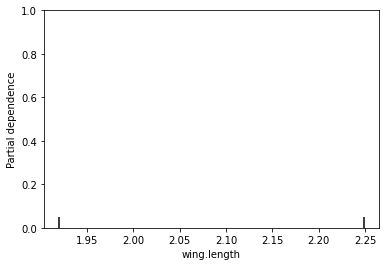

In [23]:
plot_partial_dependence(model, X, ['wing.length'])
plt.ylim((0.0,1))

In [256]:
xgb_model.fit(X_train, y_train)
xgb_model.coef__ = xgb_model.coef_
xgb_model.intercept__ = xgb_model.intercept_

[02:16:54] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




(0.0, 0.2)

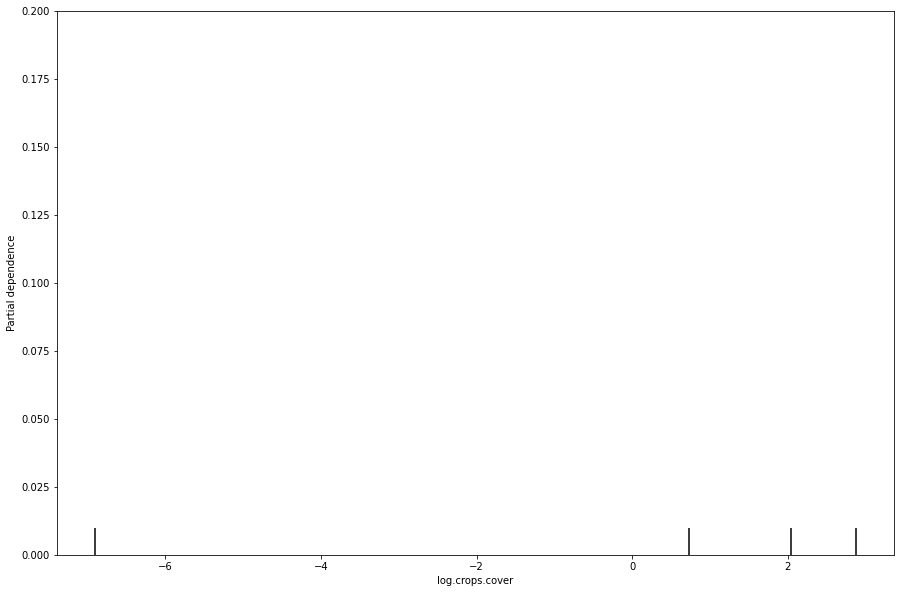

In [257]:
plot_partial_dependence(xgb_model, X, ['log.crops.cover'], line_kw={"color": 'lightblue'})
plt.ylim((0.0,0.2))

In [ ]:
#make pdp of top 10 common vector/citation variables to see if there is correllation, if shape of the curve is the same
# if they are not the same, this is a good thing

In [ ]:
#after pdp, type up summary document and compare variable importance(of all 3), r2 of citation, target shuffling, 
#etc and send to dr han

## target shuffling - make sure its getting shuffled properly

In [786]:
data = original_clean.reset_index()
data['leish'] = 0
l = data[['species', 'leish']]

In [798]:
## From the hyperopt docs

from hyperopt import hp
from hyperopt import fmin, tpe
'''
## For the argument named 'a', choose either of the two tuples, each of which has a second
## argument drawn from a given distribution and given a name ('c1'/'c2')
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

'''
###TRY TO GET THE AUC, CHANGE THE THRESHHOLD PROBABILITY

def val_test(best, train_x, train_y, val_x, val_y, graph=False):
    params = {'max_depth': int(best['max_depth']), 'gamma': best['gamma'],
                  'learning_rate': best['learning_rate'], 'n_estimators': int(best['n_estimators']),
                  'scale_pos_weight': int(best['scale_pos_weight']), 'colsample_bytree': best['colsample_bytree']}
    model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
    model.fit(train_x, train_y)

    

    #use the mean of the probabilities as the threshold for a positive prediction
    prob = np.array(pd.DataFrame(model.predict_proba(val_x))[1])
    for x in range(len(prob)):
        if prob[x] > mean(np.array(pd.DataFrame(model.predict_proba(val_x))[1])):
            prob[x] = 1
        else:
            prob[x] = 0
        
    y_preds = prob
    
               
#         plot_roc_curve(model, val_x, val_y)
#         plt.ylabel('True Positive Rate')
#         plt.xlabel('False Positive Rate')
#         plt.show()
               
    return roc_auc_score(val_y, y_preds)

target_shuffle = []
def do_nested_cv(data):
    '''
    - Split data into train, test
    - Split train into k (stratified) folds
    '''
    
    # Begin code here
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    
    cv = StratifiedKFold(n_splits=3)
    folds = cv.split(X_train, y_train)
    

    
    # End code here
    models_with_scores = []
    for (train, val) in folds:
        '''
        - Split x into n more (stratified) folds
        - Now, use Bayesian optimization to minimize objective function
        - After Bayesian optimization, evaluate the model on val and store the model
        '''
        # Begin code here
        train_x, train_y = X_train.iloc[train], y_train.iloc[train]
        val_x, val_y = X_train.iloc[val], y_train.iloc[val]
        inner_cv = StratifiedKFold(n_splits=3)
        
        inner_folds = inner_cv.split(train_x, train_y)
        inner_folds = [(train,test) for train, test in inner_folds]
        
        def objective_function(params):
            '''
            Given a set of n (inner) folds, train n models and return the average validation loss over all folds.
            '''
            scores = []
            params = {'max_depth': int(params[0]), 'gamma': params[1],
                      'learning_rate': params[2], 'n_estimators': int(params[3]),
                      'scale_pos_weight': int(params[4]), 'colsample_bytree': params[5]}

            for (itrain, ival) in inner_folds:
                # Begin code here
                '''
                - Train a model on n
                - Evaluate on val
                - Store the score to return the average over all folds
                '''
                inner_train_x, inner_train_y = train_x.iloc[itrain], train_y.iloc[itrain]
                inner_val_x, inner_val_y = train_x.iloc[ival], train_y.iloc[ival]
                
                

                model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
                model.fit(inner_train_x, inner_train_y)
            
                y_preds = model.predict(inner_val_x)
                scores.append(1-roc_auc_score(inner_val_y, y_preds))

            return np.mean(scores)
                # End code here
            
        
        #bayes

        space = hp.choice('a', [(hp.uniform('max_depth', 0, 10),
                                 hp.uniform('gamma', 10, 1000), 
                                 hp.uniform('learning_rate', 0, 1), 
                                 hp.uniform('n_estimators', 100, 200),
                                 hp.uniform('scale_pos_weight', 0, 15),
                                 hp.uniform('colsample_bytree', 0.2, 1)
                                )])
        

            
        best = fmin(objective_function, space, algo=tpe.suggest, max_evals=100)
        models_with_scores.append((best, val_test(best, train_x, train_y, val_x, val_y)))
        
        target_shuffle.append((best, val_test(best, train_x, train_y, val_x, val_y)))

        # End code here
        

    
    '''
    - Now, there are k models. Pick the best one, or create an ensemble model
    '''
    # Begin code here
    models_with_scores = sorted(models_with_scores, key = lambda x: x[1])
    best_params_overall = models_with_scores[-1][0]
    
    final_test_score = val_test(best_params_overall, X_train, y_train, X_test, y_test, True)
    print("Final Test Score is " + str(final_test_score))
    print('best = ' + str(best_params_overall))
    # End code here
    


In [813]:
#do shuffling and nested cv


for i in range(50):
    data = original_clean.reset_index()
    l = data[['species', 'leish']]
    #shuffle leish column
    shuffle = pd.DataFrame(l.sample(frac = 0.078))
    data['leish'] = 0
    for j in range(len(data)):
        for i in range(len(shuffle)):
            if data.loc[j, 'species'] == shuffle.reset_index().loc[i, 'species']:
                data.loc[j, 'leish'] = 1
    data = data.set_index('species')
    do_nested_cv(data)

100%|█████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23trial/s, best loss: 0.5]
Final Test Score is 0.39868421052631575
best = {'a': 0, 'colsample_bytree': 0.42680570549609737, 'gamma': 10.737377455382958, 'learning_rate': 0.005385125573492548, 'max_depth': 6.837880339246453, 'n_estimators': 166.85484004694615, 'scale_pos_weight': 12.596058604241607}
100%|██████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35trial/s, best loss: 0.4067460317460318]
Final Test Score is 0.5342105263157895
best = {'a': 0, 'colsample_bytree': 0.5012445069456858, 'gamma': 10.595284940359917, 'learning_rate': 0.6819288002338191, 'max_depth': 5.53836032776211, 'n_estimators': 103.6620141486637, 'scale_pos_weight': 8.45437423604087}
100%|█████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16trial/s, best loss: 0.5]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.616266664966799, 'gamma': 949.7608514268

100%|█████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23trial/s, best loss: 0.5]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.5342622333858686, 'gamma': 458.62346293621715, 'learning_rate': 0.9022349276315355, 'max_depth': 0.2780182827388933, 'n_estimators': 140.78564498173907, 'scale_pos_weight': 8.297817933219903}
100%|█████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16trial/s, best loss: 0.43452380952380953]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.36251624698918994, 'gamma': 144.53301285719579, 'learning_rate': 0.6003895151433781, 'max_depth': 9.194276359469603, 'n_estimators': 127.03458586393309, 'scale_pos_weight': 10.411102245720278}
100%|█████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20trial/s, best loss: 0.44047619047619047]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.8872800608328566, 'gamma': 927.2266385470706, 'learning_rate': 0.8147

In [814]:
np.mean([target_shuffle[x][1] for x in range(50)])

0.5021402597402598

# actual model

In [314]:
## From the hyperopt docs

from hyperopt import hp
from hyperopt import fmin, tpe
'''
## For the argument named 'a', choose either of the two tuples, each of which has a second
## argument drawn from a given distribution and given a name ('c1'/'c2')
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

'''
###TRY TO GET THE AUC, CHANGE THE THRESHHOLD PROBABILITY

def val_test(best, train_x, train_y, val_x, val_y, graph=False):
    params = {'max_depth': int(best['max_depth']), 'gamma': best['gamma'],
                  'learning_rate': best['learning_rate'], 'n_estimators': int(best['n_estimators']),
                  'scale_pos_weight': int(best['scale_pos_weight']), 'colsample_bytree': best['colsample_bytree']}
    model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', objective = 'binary:logistic', **params)
    model.fit(train_x, train_y)

    

    #use the mean of the probabilities as the threshold for a positive prediction
    prob = np.array(pd.DataFrame(model.predict_proba(val_x))[1])
    for x in range(len(prob)):
        if prob[x] > np.mean(np.array(pd.DataFrame(model.predict_proba(val_x))[1])):
            prob[x] = 1
        else:
            prob[x] = 0
        
    y_preds = prob
    
               
#         plot_roc_curve(model, val_x, val_y)
#         plt.ylabel('True Positive Rate')
#         plt.xlabel('False Positive Rate')
#         plt.show()
               
    return roc_auc_score(val_y, y_preds)

original_models = []
def do_nested_cv(data):
    '''
    - Split data into train, test
    - Split train into k (stratified) folds
    '''
    
    # Begin code here
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    
    cv = StratifiedKFold(n_splits=3)
    folds = cv.split(X_train, y_train)
    

    
    # End code here
    models_with_scores = []
    for (train, val) in folds:
        '''
        - Split x into n more (stratified) folds
        - Now, use Bayesian optimization to minimize objective function
        - After Bayesian optimization, evaluate the model on val and store the model
        '''
        # Begin code here
        train_x, train_y = X_train.iloc[train], y_train.iloc[train]
        val_x, val_y = X_train.iloc[val], y_train.iloc[val]
        inner_cv = StratifiedKFold(n_splits=3)
        
        inner_folds = inner_cv.split(train_x, train_y)
        inner_folds = [(train,test) for train, test in inner_folds]
        
        def objective_function(params):
            '''
            Given a set of n (inner) folds, train n models and return the average validation loss over all folds.
            '''
            scores = []
            params = {'max_depth': int(params[0]), 'gamma': params[1],
                      'learning_rate': params[2], 'n_estimators': int(params[3]),
                      'scale_pos_weight': int(params[4]), 'colsample_bytree': params[5]}

            for (itrain, ival) in inner_folds:
                # Begin code here
                '''
                - Train a model on n
                - Evaluate on val
                - Store the score to return the average over all folds
                '''
                inner_train_x, inner_train_y = train_x.iloc[itrain], train_y.iloc[itrain]
                inner_val_x, inner_val_y = train_x.iloc[ival], train_y.iloc[ival]
                
                

                model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params, objective='binary:logistic')
                model.fit(inner_train_x, inner_train_y)
            
                y_preds = model.predict(inner_val_x)
                scores.append(1-roc_auc_score(inner_val_y, y_preds))

            return np.mean(scores)
                # End code here
            
        
        #bayes

        space = hp.choice('a', [(hp.uniform('max_depth', 0, 10),
                                 hp.uniform('gamma', 10, 1000), 
                                 hp.uniform('learning_rate', 0, 1), 
                                 hp.uniform('n_estimators', 100, 200),
                                 hp.uniform('scale_pos_weight', 0, 15),
                                 hp.uniform('colsample_bytree', 0.2, 1)
                                )])
        

            
        best = fmin(objective_function, space, algo=tpe.suggest, max_evals=100)
        models_with_scores.append((best, val_test(best, train_x, train_y, val_x, val_y)))
        
        original_models.append((best, val_test(best, train_x, train_y, val_x, val_y)))

        # End code here
        

    
    '''
    - Now, there are k models. Pick the best one, or create an ensemble model
    '''
    # Begin code here
    models_with_scores = sorted(models_with_scores, key = lambda x: x[1])
    best_params_overall = models_with_scores[-1][0]
    
    final_test_score = val_test(best_params_overall, X_train, y_train, X_test, y_test, True)
    print("Final Test Score is " + str(final_test_score))
    print('best = ' + str(best_params_overall))
    # End code here
    


In [99]:
import warnings
warnings.filterwarnings("ignore")

In [100]:
### get out a list *original_models* that has the parameters and aucs

for i in range(100):
    data = original_clean
    do_nested_cv(data)

100%|█████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59trial/s, best loss: 0.16248832866479923]
Final Test Score is 0.8244047619047619
best = {'a': 0, 'colsample_bytree': 0.6497809521686028, 'gamma': 10.717929498055696, 'learning_rate': 0.6783727366810264, 'max_depth': 2.806771536852832, 'n_estimators': 107.29642415806977, 'scale_pos_weight': 9.973324446449979}
100%|█████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28trial/s, best loss: 0.16461251167133517]
Final Test Score is 0.7217261904761906
best = {'a': 0, 'colsample_bytree': 0.2060719178035304, 'gamma': 11.471149761549782, 'learning_rate': 0.9904510058189955, 'max_depth': 7.174920468262018, 'n_estimators': 153.35632006790868, 'scale_pos_weight': 9.565003235597425}
100%|███████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38trial/s, best loss: 0.142390289449113]
Final Test Score is 0.8400297619047619
best = {'a': 0, 'colsample_bytree': 0.5936320838222222, 'gamma': 

100%|█████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26trial/s, best loss: 0.22406629318394022]
Final Test Score is 0.859375
best = {'a': 0, 'colsample_bytree': 0.20723735473031885, 'gamma': 16.771118879449006, 'learning_rate': 0.021985107388432845, 'max_depth': 7.826632997869563, 'n_estimators': 192.172688540036, 'scale_pos_weight': 14.615737551656608}
100%|██████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36trial/s, best loss: 0.2892857142857143]
Final Test Score is 0.7217261904761906
best = {'a': 0, 'colsample_bytree': 0.20376925499721835, 'gamma': 35.42348891586058, 'learning_rate': 0.9125902114183995, 'max_depth': 2.8670686435641195, 'n_estimators': 140.98315285175215, 'scale_pos_weight': 13.81344017114472}
100%|██████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40trial/s, best loss: 0.2179971988795518]
Final Test Score is 0.793154761904762
best = {'a': 0, 'colsample_bytree': 0.996048861915743, 'gamma': 37.998935

100%|██████████████████████████████████████████████| 100/100 [01:20<00:00,  1.23trial/s, best loss: 0.1564892623716153]
Final Test Score is 0.90625
best = {'a': 0, 'colsample_bytree': 0.380742723168324, 'gamma': 13.86826520716869, 'learning_rate': 0.6977214462024014, 'max_depth': 9.976951781832446, 'n_estimators': 129.64136800971733, 'scale_pos_weight': 9.162154376185683}
100%|█████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48trial/s, best loss: 0.15835667600373482]
Final Test Score is 0.7790178571428572
best = {'a': 0, 'colsample_bytree': 0.6677862818484309, 'gamma': 18.424913558737416, 'learning_rate': 0.9735238927664216, 'max_depth': 1.5227349749153891, 'n_estimators': 143.0242322456882, 'scale_pos_weight': 14.787380851672745}
100%|███████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32trial/s, best loss: 0.255859010270775]
Final Test Score is 0.890625
best = {'a': 0, 'colsample_bytree': 0.9354341099386823, 'gamma': 17.296040155480647, 'l

100%|█████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34trial/s, best loss: 0.17829131652661057]
Final Test Score is 0.7671130952380951
best = {'a': 0, 'colsample_bytree': 0.384825329536029, 'gamma': 35.55714006062912, 'learning_rate': 0.5156434122730347, 'max_depth': 2.3690754523413142, 'n_estimators': 199.99684622406104, 'scale_pos_weight': 8.475594023802765}
100%|██████████████████████████████████████████████| 100/100 [01:11<00:00,  1.41trial/s, best loss: 0.1367647058823529]
Final Test Score is 0.8854166666666667
best = {'a': 0, 'colsample_bytree': 0.2055490020623602, 'gamma': 11.36345343288086, 'learning_rate': 0.7726659446095206, 'max_depth': 6.418981721363868, 'n_estimators': 181.2344795997615, 'scale_pos_weight': 14.040175886473527}
100%|█████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35trial/s, best loss: 0.17044817927170866]
Final Test Score is 0.7879464285714286
best = {'a': 0, 'colsample_bytree': 0.3113958400144072, 'gamma': 36

In [101]:
import pickle
# create a binary pickle file 
f = open("original_models_parameters.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(original_models,f)

# close file
f.close()

In [348]:
original_models = pd.read_pickle(r'original_models_parameters.pkl')

In [389]:
# take these parameters to R
param_top_ten = sorted(original_models, key = lambda x: x[1])[-10:]
params = [a[0] for a in p]
param_df = pd.DataFrame(params).drop(columns = ['a'])
param_df.to_csv('original_models_parameters_10.csv')

In [351]:
####
#FOR EACH OF THE 10 BEST PERFORMING PARAMETERS IN ORIGINAL_MODELS, DO EVALUATIONS ON 10 RANDOM STATE SPLITS
####

param_dict = sorted(original_models, key = lambda x: x[1])[-10:]
auc_list = []
data = original_clean

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': int(param_dict[x][0]['n_estimators']),
                              'scale_pos_weight': int(param_dict[x][0]['scale_pos_weight']), 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    X = data.iloc[:,:-1] # Feature matrix in pd.DataFrame format
    y = data.iloc[:,-1] # Target vector in pd.Series format
    
    for q in range(10):

        # Making train and test sets for both X and y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

        # Instantiate an XGBoost object with hyperparameters
        xgb_clf = xgb.XGBClassifier(**params,
                                    objective='binary:logistic', booster='gbtree', 
                                    n_jobs=2, eval_metric = 'logloss', use_label_encoder=False)

        # Train the model with train data sets
        xgb_clf.fit(X_train, y_train)

        prob = np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])
        for x in range(len(prob)):
            if prob[x] > np.mean(np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])):
                prob[x] = 1
            else:
                prob[x] = 0

        y_pred = prob
        y_true = y_test # True values

#         print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

        auc_list.append(roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]))

        #less ugly step curve
#         plot_roc_curve(xgb_clf, X_test, y_test, color='lightgrey', ax=ax)

# ax.get_legend().remove()
# print(auc_list)
print('median AUC: ' + str(np.median(auc_list)))
print('mean AUC: ' + str(np.mean(auc_list)))

median AUC: 0.882440476190476
mean AUC: 0.8779761904761907


Text(0.5, 1.0, 'Nested Cross Validation AUC Scores')

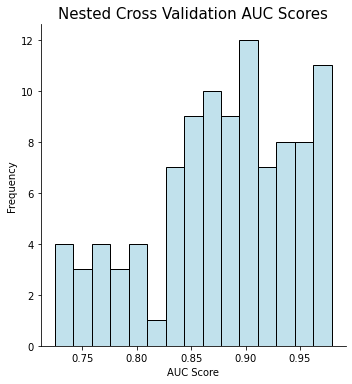

In [355]:
#from the 10 best models, 100 aucs in a histogram
sns.displot(auc_list, bins = 15, color='lightblue')
plt.xlabel('AUC Score')
plt.ylabel('Frequency')
plt.title('Nested Cross Validation AUC Scores', fontsize = 15)

#median = 0.897
#mean = 0.883

### predictions

In [352]:
#100 iterations using random state and 10 best params
#for each best param, do 10 predictions using random states

data = original_clean
param_dict = sorted(original_models, key = lambda x: x[1])[-10:]
prediction_matrix = pd.DataFrame(original_clean.reset_index()['species'])  
models_list_proven = []

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': int(param_dict[x][0]['n_estimators']),
                              'scale_pos_weight': int(param_dict[x][0]['scale_pos_weight']), 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    
    for u in range(10):
        X, y = data.iloc[:,:-1], data.iloc[:,-1]
        #stratify to make sure the 1s are distributed evenly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
        
        model = XGBClassifier(**params, booster='gbtree', objective='binary:logistic', eval_metric = 'logloss', use_label_encoder=False)
        model.fit(X_train, y_train)
        
        models_list_proven.append(model)

        #predictions in an array
        y = model.predict_proba(X)

        #match prediction to the species for this split
        probability_table = X.reset_index() #get the species in the test set
        probability_table['probability'] = pd.DataFrame(pd.DataFrame(y)[1]) #get the probabilities
        probability_table = probability_table[['species', 'probability']]
        #put the prediction in the big df
        for a in range(len(prediction_matrix)):
            for b in range(len(probability_table)):
                if prediction_matrix.loc[a, 'species'] == probability_table.loc[b, 'species']:
                    prediction_matrix.loc[a, str(x) + '.' + str(u)] = probability_table.loc[b, 'probability']

In [353]:
#CHANGED GAMMA
#get a prediction table with the median probability and percentile for each species
prediction_matrix['std'] = pd.DataFrame(prediction_matrix.std(axis=1))
prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.median(axis=1))
top_predictions = prediction_matrix
top_predictions['percentile'] = top_predictions.probability.rank(pct=True)
top_predictions = top_predictions[top_predictions['probability'] >= 0.5].reset_index(drop=True)
top_predictions = top_predictions[['species', 'probability','std', 'percentile']].reset_index(drop=True)

#add real labels
top_predictions = getstatus(top_predictions, 'leish')
top_predictions = top_predictions.fillna(0)

#sort by probability
final_predictions = top_predictions.sort_values(by ='probability', ascending=False).reset_index(drop=True)
final_predictions = final_predictions.round(3)
final_predictions

,species,probability,std,percentile,potential/proven
0,Bichromomyia flaviscutellata,0.939,0.154,1.000,2.0
1,Psychodopygus panamensis,0.917,0.096,0.998,2.0
2,Psychodopygus davisi,0.916,0.098,0.996,2.0
3,Psychodopygus wellcomei,0.915,0.116,0.994,2.0
4,Nyssomyia whitmani,0.913,0.104,0.992,2.0
5,Trichophoromyia ubiquitalis,0.910,0.093,0.990,2.0
6,Nyssomyia intermedia,0.909,0.117,0.988,2.0
7,Psathyromyia (Psathyromyia) shannoni,0.907,0.102,0.984,2.0
8,Nyssomyia antunesi,0.907,0.109,0.984,1.0
9,Nyssomyia neivai,0.907,0.122,0.984,2.0


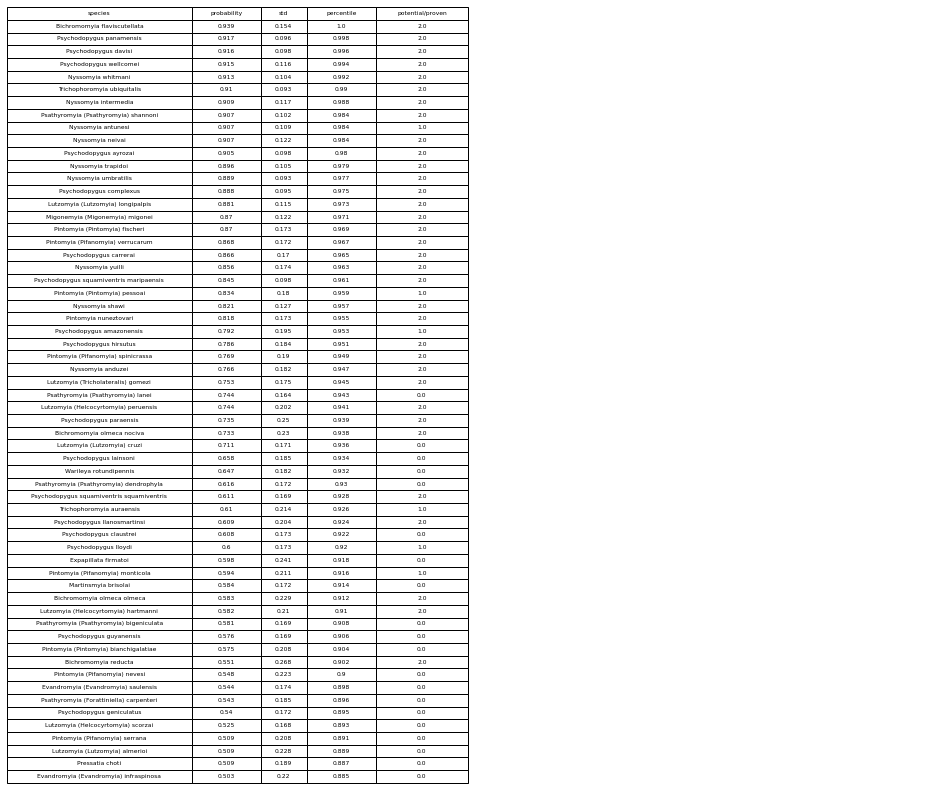

In [354]:
from matplotlib.backends.backend_pdf import PdfPages
fig, ax =plt.subplots(figsize=(8,12))
# ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=final_predictions.values,colLabels=final_predictions.columns,loc='left', cellLoc = 'center', colWidths=[0.4, 0.15, 0.1, 0.15, 0.2])


#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("proven predictions.pdf")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [ ]:
table = final_predictions.set_index('species').round(2)
from tabulate import tabulate

print(tabulate(table, headers = 'keys', tablefmt = 'psql'))

### probability distributions for top sandflies

In [356]:
density = prediction_matrix.set_index('species')
density = density.loc[final_predictions['species'].to_list()]

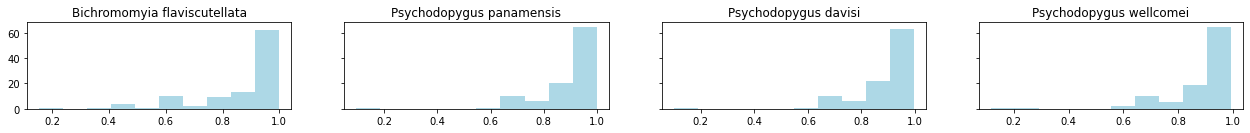

In [357]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

# left  = 0.125  # the left side of the subplots of the figure
# right = 0.9    # the right side of the subplots of the figure
# bottom = 0.1   # the bottom of the subplots of the figure
# top = 0.9      # the top of the subplots of the figure
# wspace = 0.2   # the amount of width reserved for blank space between subplots
# hspace = 0.2   # the amount of height reserved for white space between subplots

for x in range(4):
    sandfly = density.reset_index().loc[x, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven1.png', bbox_inches='tight')

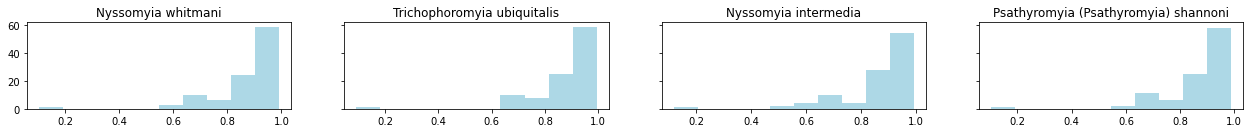

In [358]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+4, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven2.png', bbox_inches='tight')

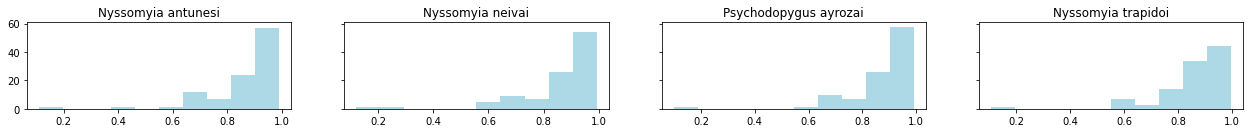

In [359]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+8, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven3.png', bbox_inches='tight')

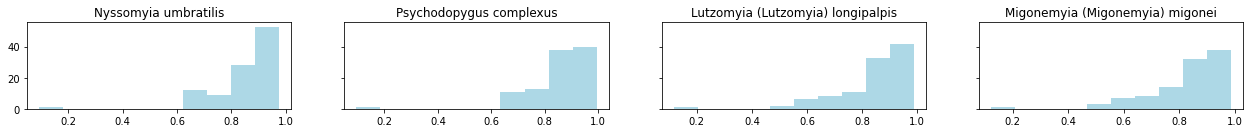

In [360]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+12, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven4.png', bbox_inches='tight')

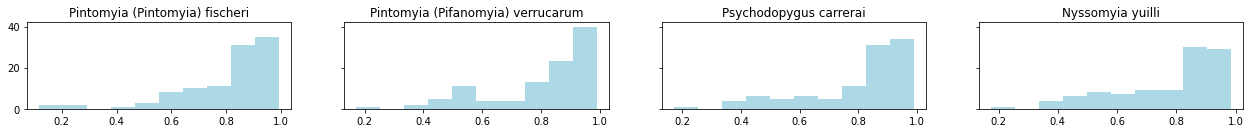

In [361]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)


for x in range(4):
    sandfly = density.reset_index().loc[x+16, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven5.png', bbox_inches='tight')

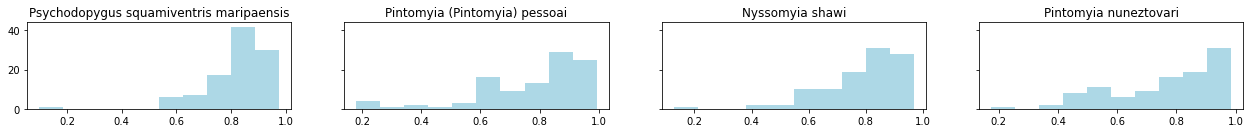

In [362]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+20, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven6.png', bbox_inches='tight')

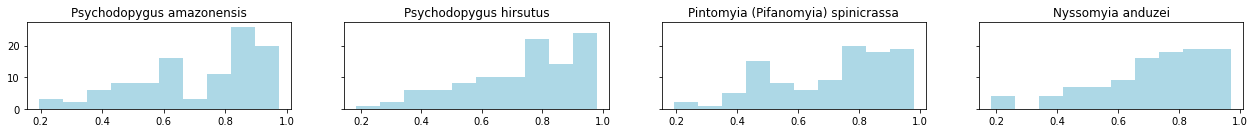

In [363]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+24, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven7.png', bbox_inches='tight')

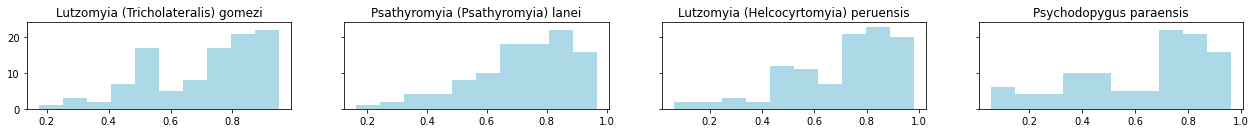

In [364]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+28, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven8.png', bbox_inches='tight')

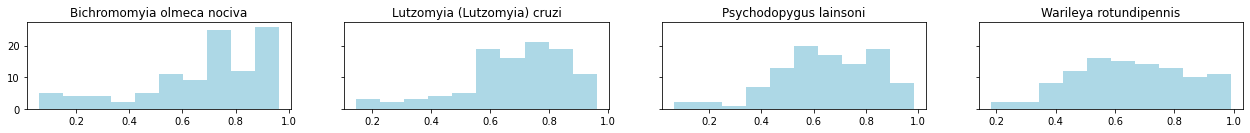

In [365]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+32, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven9.png', bbox_inches='tight')

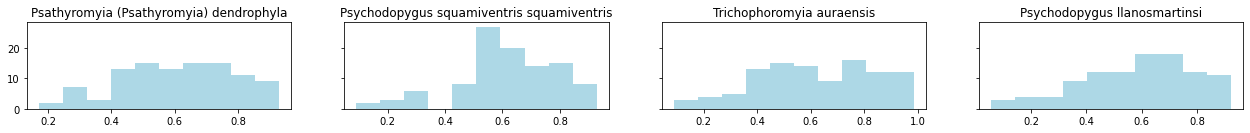

In [366]:
### NON PROVEN PREDICTIONS

fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+36, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven10.png', bbox_inches='tight')

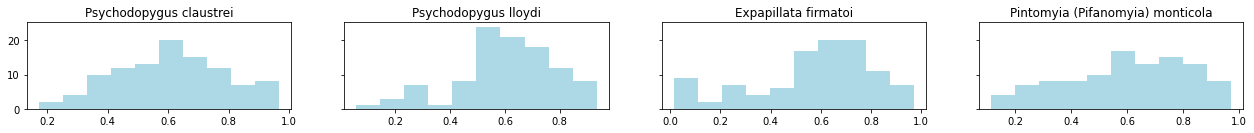

In [367]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+40, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven11.png', bbox_inches='tight')

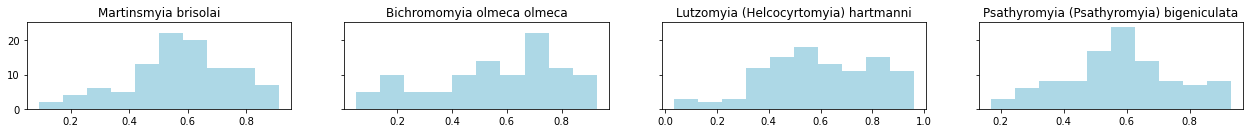

In [368]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+44, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven12.png', bbox_inches='tight')

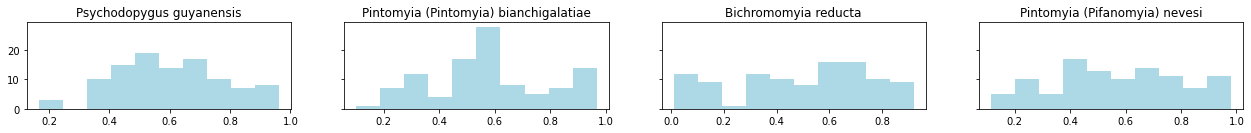

In [369]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+48, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('proven13.png', bbox_inches='tight')

### variable importance


In [370]:
#takes in modelslist created in the predtable function, returns dataframe of variables and importances
def var_impt(list_of_models):

    impt_matrix = pd.DataFrame(list_of_models[0].feature_importances_, original_clean.columns[0:82])
    for x in range(1, len(list_of_models)):
        var_array = pd.DataFrame(list_of_models[x].feature_importances_, original_clean.columns[0:82])
        impt_matrix[x] = var_array[0]
        
    var_impt_df = pd.DataFrame()
    var_impt_df['feature'] = original_clean.columns[0:82]
    var_impt_df = var_impt_df.set_index('feature')
    for var in original_clean.columns[0:82]:
        mean = impt_matrix.loc[var].mean()
        var_impt_df.loc[var, 'importance'] = mean
        std = impt_matrix.loc[var].std()
        var_impt_df.loc[var, 'std'] = std

    var_impt_df = var_impt_df.reset_index()
    
    return impt_matrix, var_impt_df.round(3).sort_values(by='importance', ascending=False)

In [371]:
var_impt_df = var_impt(models_list_proven)[1].head(30)

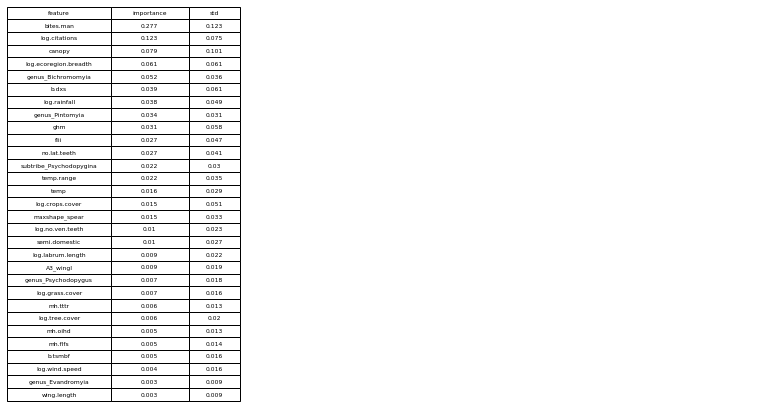

In [372]:
fig, ax =plt.subplots(figsize=(9,6))
# ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=var_impt_df.values,colLabels=var_impt_df.columns,loc='left', cellLoc = 'center', colWidths=[0.2, 0.15, 0.1, 0.15])


#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("proven variable importance.pdf")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [373]:
#get a dataframe with the feature, and lower and higher confidence bound for its importance
var_confidence = pd.DataFrame()
var_confidence['feature'] = 0
var_confidence['lower'] = 0
var_confidence['higher'] = 0

impt_df = var_impt(models_list_proven)[0]

for x in range(len(var_impt_df)):
    feature = var_impt_df['feature'].to_list()[x]
    impt = var_impt_df['importance'].to_list()[x]
    var_confidence.loc[x, 'feature'] = feature
    var_confidence.loc[x, 'importance'] = impt
    var_confidence.loc[x, 'lower'] = getconf_interval_var(impt_df.loc[feature])[0]
    var_confidence.loc[x, 'higher'] = getconf_interval_var(impt_df.loc[feature])[1]

var_confidence = var_confidence.sort_values(by='importance', ascending=False)

In [374]:
var_confidence

,feature,lower,higher,importance
0,bites.man,0.253663,0.300694,0.277
1,log.citations,0.109042,0.138341,0.123
2,canopy,0.060002,0.099455,0.079
3,log.ecoregion.breadth,0.049298,0.073037,0.061
4,genus_Bichromomyia,0.045490,0.059249,0.052
5,b.dxs,0.026893,0.050827,0.039
6,log.rainfall,0.029109,0.048235,0.038
7,genus_Pintomyia,0.028137,0.040185,0.034
8,ghm,0.021057,0.043474,0.031
9,flii,0.018337,0.036738,0.027


In [267]:
'''
citations - red
biogeography - light blue
morphology/genus - black
ecology - green
'''
color_list = ['green', 'red', 'green', 'black', 'lightblue',
              'lightblue', 'lightblue', 'lightblue', 'green', 'black',
              'lightblue', 'black', 'lightblue', 'lightblue', 'green',
              'black', 'black', 'green', 'black', 'green']

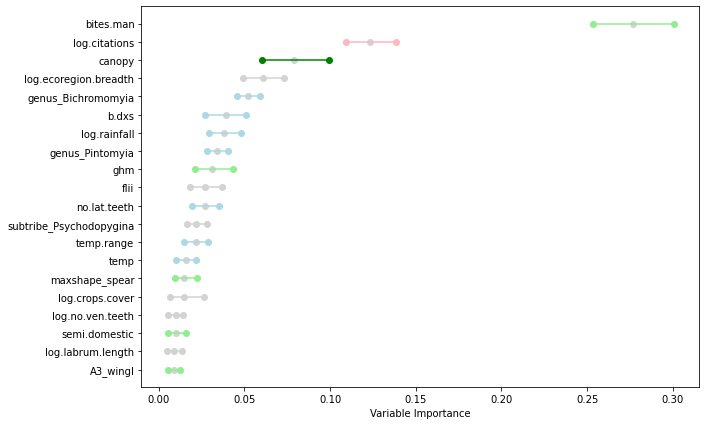

In [375]:
# plot the importances with their confidence intervals
x = var_confidence.head(20)['feature'].to_list()
y = var_confidence.head(20)['importance'].to_list()
lower = var_confidence['lower'].head(20)
higher = var_confidence['higher'].head(20)

plt.scatter(y, x, color = 'lightgrey')
#using https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
for lower,upper,y in zip(var_confidence['lower'].head(20), var_confidence['higher'].head(20), range(len(var_confidence))):
    plt.plot((lower,upper),(y,y),'bo-',color=color_list[y])

plt.yticks(range(len(var_confidence.head(20))), list(var_confidence['feature'].head(20)))

# plt.errorbar(y, x, fmt="o")
plt.rcParams["figure.figsize"] = (10,7)
plt.xlabel('Variable Importance')
plt.gca().invert_yaxis()
# plt.show()
plt.savefig('proven_var_imp_figure.png', bbox_inches='tight')

### pdp

In [376]:
og = pd.read_csv('final2/vector trait data final.csv')
data = original_clean
X, y = data.iloc[:,:-1], data.iloc[:,-1]

In [46]:
import warnings
warnings.filterwarnings('ignore')

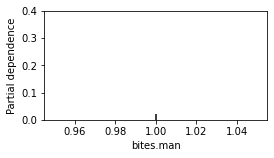

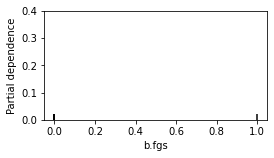

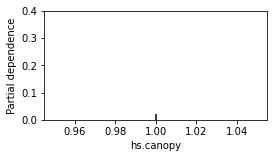

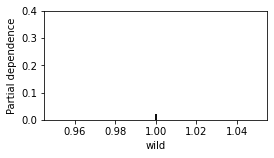

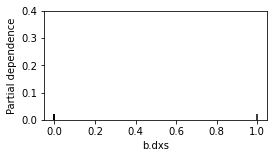

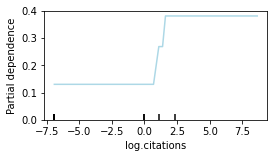

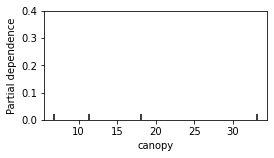

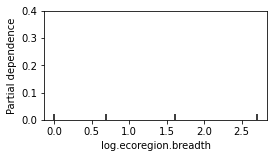

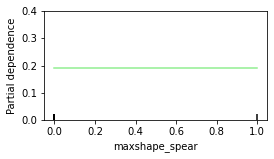

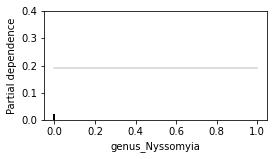

In [377]:
# fig = plt.figure()
# ax = plt.subplot(111)
model_type = models_list_proven
color_list = ['lightgreen', 'lightpink', 'green', 'lightgrey', 'lightblue',
              'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgrey',
              'lightblue', 'lightgrey', 'lightblue', 'lightblue', 'lightgreen',
              'lightgrey', 'lightgrey', 'lightgreen', 'lightgrey', 'lightgreen']
for a in range(10):
    fig = plt.figure()
    ax = plt.subplot(111)

    variable = importance.loc[a, 'feature']
    color = color_list[a]

    model0_plot = PartialDependenceDisplay.from_estimator(model_type[0], X, [variable], ax=ax,  line_kw={"color": color})
#     for x in range(1, 100):
#         model_plot = PartialDependenceDisplay.from_estimator(model_type[x], X, [variable], ax=model0_plot.axes_,  line_kw={"color": color})

    plt.ylim((0.0,0.4))
#     ax.set_ylim(self.pdp_lim[1])

    #get average line
#     ax = plt.gca()
#     line = ax.lines[0]
#     x_array = line.get_xdata()

#     y_array = ax.lines[0].get_ydata()
#     for i in range(1, 100):
#         y_array += ax.lines[i].get_ydata()
#     y_array = y_array/100
    fig.set_size_inches(4, 2)
#     plt.xlabel('')
#     plt.title(variable)
#     plt.plot(x_array, y_array, color = 'black')

# #histogram behind
# ax2 = ax.twinx()
# df_var = og['citations'].to_list()
# histogram = plt.hist(df_var, range=(0, 1), color = 'lightgrey', bins = 5, alpha = 0.4)

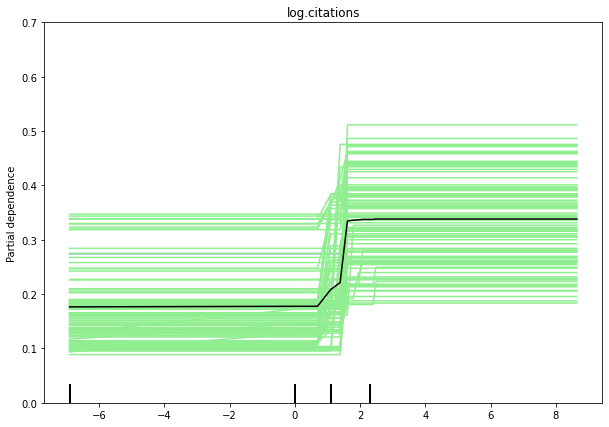

In [378]:
variable = 'log.citations'
color = 'lightgreen'
model_type = models_list_proven
model0_plot = PartialDependenceDisplay.from_estimator(model_type[10], X, [variable])
# plot_partial_dependence(model_type[0], X, [variable])

for x in range(1, 100):
    model_plot = PartialDependenceDisplay.from_estimator(model_type[x], X, [variable], ax=model0_plot.axes_,  line_kw={"color": color})

plt.ylim((0.0,0.7))

#get average line
ax = plt.gca()
line = ax.lines[0]
x_array = line.get_xdata()


y_array = ax.lines[0].get_ydata()
for i in range(1, 100):
    y_array += ax.lines[i].get_ydata()
y_array = y_array/100
fig.set_size_inches(4, 2)
plt.xlabel('')
plt.title(variable)
plt.plot(x_array, y_array, color = 'black')

In [280]:
partial_dependence(model_type[0], X, ['log.citations'], response_method ='predict_proba')

(array([[0.22685409, 0.22685409, 0.22685409, 0.36660522, 0.36660522,
         0.36660522, 0.36660522, 0.36660522, 0.36660522, 0.36660522,
         0.36660522, 0.36660522, 0.36660522, 0.36660522, 0.36660522,
         0.36660522, 0.36660522, 0.36660522, 0.36660522, 0.36660522,
         0.36660522, 0.36660522, 0.36660522, 0.36660522, 0.36660522,
         0.36660522, 0.36660522, 0.36660522, 0.36660522, 0.36660522,
         0.36660522, 0.36660522, 0.36660522]], dtype=float32),
 [array([-6.90775528e+00,  9.99500333e-04,  6.93647056e-01,  1.09894557e+00,
          1.38654433e+00,  1.60963789e+00,  1.79192612e+00,  1.94605300e+00,
          2.07956653e+00,  2.19733568e+00,  2.30268509e+00,  2.39798618e+00,
          2.48498998e+00,  2.56502628e+00,  2.70811687e+00,  2.83327217e+00,
          2.89042731e+00,  2.94449161e+00,  2.99578227e+00,  3.09108791e+00,
          3.13553769e+00,  3.17809550e+00,  3.40123071e+00,  3.46576715e+00,
          4.00735137e+00,  4.02536955e+00,  4.14315060e+00,  

In [283]:
x = partial_dependence(model_type[0], X, ['bites.man', 'log.citations'], response_method ='predict_proba')

In [292]:
x[1][1]

array([-6.90775528e+00,  9.99500333e-04,  6.93647056e-01,  1.09894557e+00,
        1.38654433e+00,  1.60963789e+00,  1.79192612e+00,  1.94605300e+00,
        2.07956653e+00,  2.19733568e+00,  2.30268509e+00,  2.39798618e+00,
        2.48498998e+00,  2.56502628e+00,  2.70811687e+00,  2.83327217e+00,
        2.89042731e+00,  2.94449161e+00,  2.99578227e+00,  3.09108791e+00,
        3.13553769e+00,  3.17809550e+00,  3.40123071e+00,  3.46576715e+00,
        4.00735137e+00,  4.02536955e+00,  4.14315060e+00,  4.30407861e+00,
        4.34381841e+00,  4.58497768e+00,  4.79579881e+00,  6.88038511e+00,
        8.64400221e+00])

In [298]:
x[0][0][0]

array([0.19443697, 0.19443697, 0.19443697, 0.33138046, 0.33138046,
       0.33138046, 0.33138046, 0.33138046, 0.33138046, 0.33138046,
       0.33138046, 0.33138046, 0.33138046, 0.33138046, 0.33138046,
       0.33138046, 0.33138046, 0.33138046, 0.33138046, 0.33138046,
       0.33138046, 0.33138046, 0.33138046, 0.33138046, 0.33138046,
       0.33138046, 0.33138046, 0.33138046, 0.33138046, 0.33138046,
       0.33138046, 0.33138046, 0.33138046], dtype=float32)

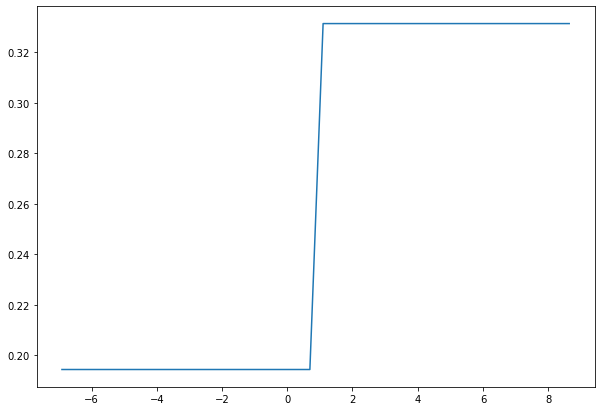

In [299]:
plt.plot(x[1][1], x[0][0][0])

In [305]:
y = partial_dependence(model_type[3], X, ['bites.man', 'log.citations'], response_method ='predict_proba')

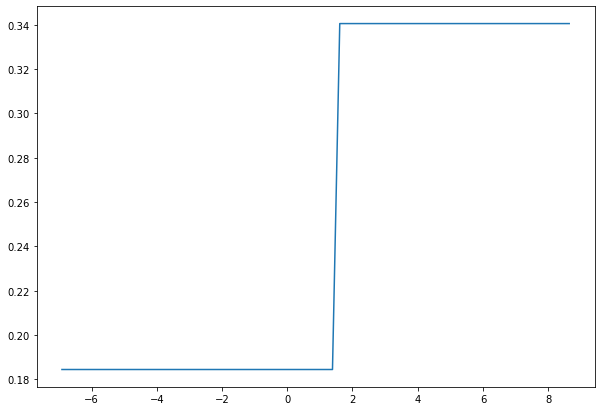

In [306]:
plt.plot(y[1][1], y[0][0][0])

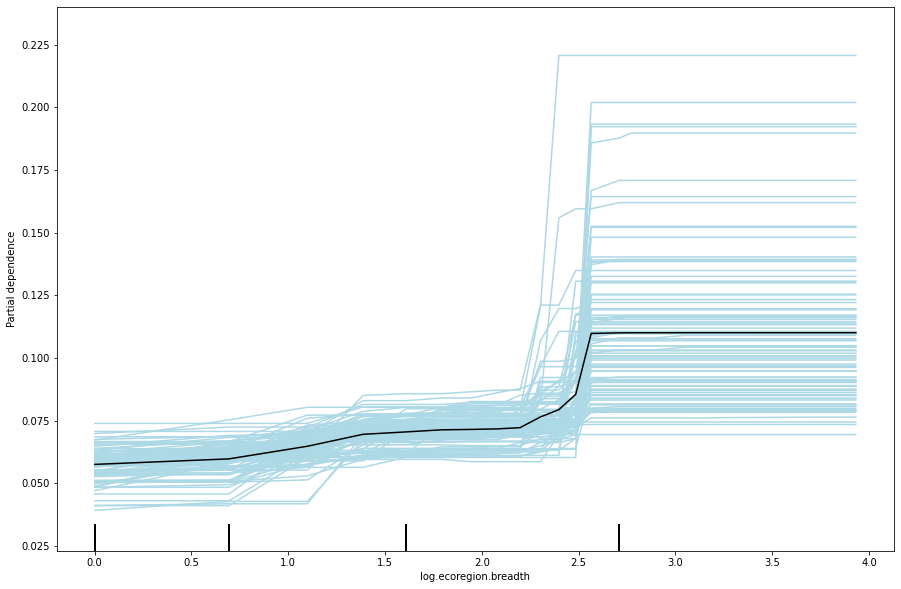

In [182]:
fig = plt.figure()
ax = plt.subplot(111)
model_type = models_list_proven
variable = 'log.ecoregion.breadth' 
color = 'lightblue'

model0_plot = plot_partial_dependence(model_type[0], X, [variable], ax=ax,  line_kw={"color": color})
for x in range(1, 100):
    model_plot = plot_partial_dependence(model_type[x], X, [variable], ax=model0_plot.axes_,  line_kw={"color": color})

plt.ylim((0.023,0.24))

#get average line
ax = plt.gca()
line = ax.lines[0]
x_array = line.get_xdata()

y_array = ax.lines[0].get_ydata()
for i in range(1, 100):
    y_array += ax.lines[i].get_ydata()
y_array = y_array/100

plt.plot(x_array, y_array, color = 'black')

# #histogram behind
# ax2 = ax.twinx()
# df_var = original[variable].to_list()
# histogram = plt.hist(df_var, range=(0, 2), color = 'lightgrey', bins = 5, alpha = 0.4)

# potential - 1 and 2

In [259]:
original = pd.read_csv('final2/one hot encoded original data.csv')
original = original.drop(columns=['Argentina', 'Belize','Bolivia', 'Brazil', 'Canada', 'CaymanIslands', 'Chile', 'Colombia',
                                  'Costa.Rica', 'Cuba', 'Dominican.Republic', 'Ecuador', 'El.Salvador', 'French.Guiana',
                                  'Guadeloupe', 'Guatemala', 'Grenada', 'Guyana', 'Haiti', 'Honduras', 'Jamaica','Martinica',
                                  'Mexico', 'Nicaragua', 'Panama', 'Paraguay','PuertoRico', 'Peru', 'Suriname',
                                  'TrinidadTobago', 'Uruguay', 'USA', 'Venezuela','VirginIslands'])
status = pd.read_csv('final2/sandfly status.csv')
#if sandfly is a proven vector for any species of leish, mark it in a new column 'cl' as 1
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2

#get cleaned train datasets in a list
parasite = 'leish'
for j in range(len(original)):
    for i in range(len(status)):
        if original.loc[j, 'species'] == status.loc[i, 'species']:
            original.loc[j, parasite] = status.loc[i, parasite]

#fill the remaining vector status column with 0s, then binarize the status
original[parasite] = original[parasite].fillna(0).map(lambda x : x//2)
#set the index as the species name
original = original.set_index('species')
#drop unnecessary columns
original_clean = original.drop(columns=['Unnamed: 0'])

In [260]:
original_clean['leish'].value_counts()

0.0    443
1.0     69
Name: leish, dtype: int64

In [261]:
####LOOK AT CORRELLATED VARIABLES?? - take out more than 0.7
#tribe_Hertigiini is corr w 'genus_Warileya'
#subtribe_hertigiina is corr w 'genus_Warileya'
#peri is corr w semi.domestic
#'genus_Brumptomyia' is corr w 'subtribe_Brumptomyiina'
#'genus_Micropygomyia' is corr w 'subtribe_Sergentomyiina'

#wing_width / hs.canopy
#wing_width / hs.floor
#labruml_wingl / log.labrum.length
#log.grass.cover / log.shrub.cover
#domestic / intra
#temp / wing.width
#log.elevation / temp
#log.temp.var / temp.range
#maxshape_sabre / genus_Brumptomyia
#log.dental.depth / log.labrum.length


# pd.DataFrame(original_clean.corr()).to_csv('correllation.csv')
original_clean = original_clean.drop(columns=['subtribe_Sergentomyiina', 'subtribe_Brumptomyiina',
                                              'peri', 'subtribe_Hertigiina', 'tribe_Hertigiini',
                                              'wing.width', 'labruml_wingl', 'log.shrub.cover',
                                              'intra', 'log.elevation', 'log.temp.var', 'maxshape_sabre', 'log.dental.depth'])

In [263]:
## From the hyperopt docs

from hyperopt import hp
from hyperopt import fmin, tpe
'''
## For the argument named 'a', choose either of the two tuples, each of which has a second
## argument drawn from a given distribution and given a name ('c1'/'c2')
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

'''
###TRY TO GET THE AUC, CHANGE THE THRESHHOLD PROBABILITY

def val_test(best, train_x, train_y, val_x, val_y, graph=False):
    params = {'max_depth': int(best['max_depth']), 'gamma': best['gamma'],
                  'learning_rate': best['learning_rate'], 'n_estimators': int(best['n_estimators']),
                  'scale_pos_weight': int(best['scale_pos_weight']), 'colsample_bytree': best['colsample_bytree']}
    model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
    model.fit(train_x, train_y)

    

    #use the mean of the probabilities as the threshold for a positive prediction
    prob = np.array(pd.DataFrame(model.predict_proba(val_x))[1])
    for x in range(len(prob)):
        if prob[x] > mean(np.array(pd.DataFrame(model.predict_proba(val_x))[1])):
            prob[x] = 1
        else:
            prob[x] = 0
        
    y_preds = prob
    
               
#         plot_roc_curve(model, val_x, val_y)
#         plt.ylabel('True Positive Rate')
#         plt.xlabel('False Positive Rate')
#         plt.show()
               
    return roc_auc_score(val_y, y_preds)

original_models_potential = []
def do_nested_cv(data):
    '''
    - Split data into train, test
    - Split train into k (stratified) folds
    '''
    
    # Begin code here
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    
    cv = StratifiedKFold(n_splits=3)
    folds = cv.split(X_train, y_train)
    

    
    # End code here
    models_with_scores = []
    for (train, val) in folds:
        '''
        - Split x into n more (stratified) folds
        - Now, use Bayesian optimization to minimize objective function
        - After Bayesian optimization, evaluate the model on val and store the model
        '''
        # Begin code here
        train_x, train_y = X_train.iloc[train], y_train.iloc[train]
        val_x, val_y = X_train.iloc[val], y_train.iloc[val]
        inner_cv = StratifiedKFold(n_splits=3)
        
        inner_folds = inner_cv.split(train_x, train_y)
        inner_folds = [(train,test) for train, test in inner_folds]
        
        def objective_function(params):
            '''
            Given a set of n (inner) folds, train n models and return the average validation loss over all folds.
            '''
            scores = []
            params = {'max_depth': int(params[0]), 'gamma': params[1],
                      'learning_rate': params[2], 'n_estimators': int(params[3]),
                      'scale_pos_weight': int(params[4]), 'colsample_bytree': params[5]}

            for (itrain, ival) in inner_folds:
                # Begin code here
                '''
                - Train a model on n
                - Evaluate on val
                - Store the score to return the average over all folds
                '''
                inner_train_x, inner_train_y = train_x.iloc[itrain], train_y.iloc[itrain]
                inner_val_x, inner_val_y = train_x.iloc[ival], train_y.iloc[ival]
                
                

                model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
                model.fit(inner_train_x, inner_train_y)
            
                y_preds = model.predict(inner_val_x)
                scores.append(1-roc_auc_score(inner_val_y, y_preds))

            return np.mean(scores)
                # End code here
            
        
        #bayes

        space = hp.choice('a', [(hp.uniform('max_depth', 0, 10),
                                 hp.uniform('gamma', 10, 1000), 
                                 hp.uniform('learning_rate', 0, 1), 
                                 hp.uniform('n_estimators', 100, 200),
                                 hp.uniform('scale_pos_weight', 0, 15),
                                 hp.uniform('colsample_bytree', 0.2, 1)
                                )])
        

            
        best = fmin(objective_function, space, algo=tpe.suggest, max_evals=100)
        models_with_scores.append((best, val_test(best, train_x, train_y, val_x, val_y)))
        
        original_models_potential.append((best, val_test(best, train_x, train_y, val_x, val_y)))

        # End code here
        

    
    '''
    - Now, there are k models. Pick the best one, or create an ensemble model
    '''
    # Begin code here
    models_with_scores = sorted(models_with_scores, key = lambda x: x[1])
    best_params_overall = models_with_scores[-1][0]
    
    final_test_score = val_test(best_params_overall, X_train, y_train, X_test, y_test, True)
    print("Final Test Score is " + str(final_test_score))
    print('best = ' + str(best_params_overall))
    # End code here
    


In [264]:
### get out a list that has the parameters and aucs

for i in range(100):
    data = original_clean
    do_nested_cv(data)

 17%|██████████▌                                                   | 17/100 [00:15<01:16,  1.09trial/s, best loss: 0.5]


KeyboardInterrupt: 

In [265]:
original_models_potential = pd.read_pickle(r'original_models_potential.pkl')

[00:36:39] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.854
[00:36:39] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.874
[00:36:40] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you fi

Accuracy:  0.825
[00:36:56] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.825
[00:36:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.922
[00:36:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.767
[00:37:14] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.835
[00:37:15] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.854
[00:37:16] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.816
[00:37:33] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.864
[00:37:35] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.845
[00:37:35] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.825
[00:37:55] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.854
[00:37:56] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.845
[00:37:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

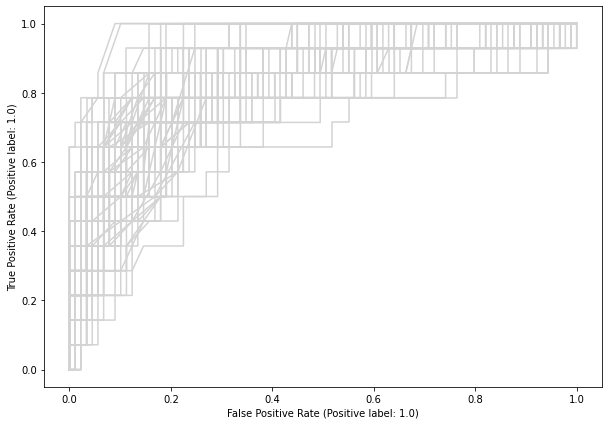

In [266]:
####
#FOR THE 10 BEST PERFORMING PARAMETERS IN no_cite_models, DO EVALUATIONS ON 10 RANDOM STATE SPLITS
####

param_dict = sorted(original_models_potential, key = lambda x: x[1])[-11:-1]
fig = plt.figure()
ax = plt.subplot(111)
auc_list = []
data = original_clean

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': param_dict[x][0]['n_estimators'],
                              'scale_pos_weight': param_dict[x][0]['scale_pos_weight'], 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    X = data.iloc[:,:-1] # Feature matrix in pd.DataFrame format
    y = data.iloc[:,-1] # Target vector in pd.Series format
    
    for q in range(10):

        # Making train and test sets for both X and y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

        # Instantiate an XGBoost object with hyperparameters
        xgb_clf = xgb.XGBClassifier(params = params,
                                    objective='binary:logistic', booster='gbtree', 
                                    n_jobs=2, eval_metric = 'logloss')

        # Train the model with train data sets
        xgb_clf.fit(X_train, y_train)

        prob = np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])
        for x in range(len(prob)):
            if prob[x] > mean(np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])):
                prob[x] = 1
            else:
                prob[x] = 0

        y_pred = prob
        y_true = y_test # True values

        print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

        auc_list.append(roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]))

        #less ugly step curve
        plot_roc_curve(xgb_clf, X_test, y_test, color='lightgrey', ax=ax)

ax.get_legend().remove()
print(auc_list)
print('AUC: ' + str(np.mean(auc_list)))

Text(0.5, 1.0, 'Nested Cross Validation AUC Scores')

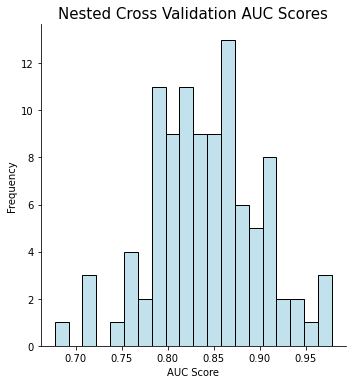

In [267]:
#from the 10 best models, 100 aucs in a histogram
sns.displot(auc_list, bins = 20, color='lightblue')
plt.xlabel('AUC Score')
plt.ylabel('Frequency')
plt.title('Nested Cross Validation AUC Scores', fontsize = 15)
#avg = 0.842

In [268]:
#100 iterations using random state and 10 best params
#for each best param, do 10 predictions using random states

data = original_clean
param_dict = sorted(original_models_potential, key = lambda x: x[1])[-11:-1]
pred_list = []
prediction_matrix = pd.DataFrame(original_clean.reset_index()['species'])  
models_list_potential = []

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': param_dict[x][0]['n_estimators'],
                              'scale_pos_weight': param_dict[x][0]['scale_pos_weight'], 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    
    for u in range(10):
        X, y = data.iloc[:,:-1], data.iloc[:,-1]
        #stratify to make sure the 1s are distributed evenly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
        
        model = XGBClassifier(params=params, booster='gbtree', objective='binary:logistic', eval_metric = 'logloss')
        model.fit(X_train, y_train)
        
        models_list_potential.append(model)

        #predictions in an array
        y = model.predict_proba(X)

        #match prediction to the species for this split
        probability_table = X.reset_index() #get the species in the test set
        probability_table['probability'] = pd.DataFrame(pd.DataFrame(y)[1]) #get the probabilities
        probability_table = probability_table[['species', 'probability']]
        #put the prediction in the big df
        for a in range(len(prediction_matrix)):
            for b in range(len(probability_table)):
                if prediction_matrix.loc[a, 'species'] == probability_table.loc[b, 'species']:
                    prediction_matrix.loc[a, str(x) + '.' + str(u)] = probability_table.loc[b, 'probability']

[00:46:41] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:46:48] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:46:55] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:47:01] WARNI

[00:49:46] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:54] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:50:00] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:50:07] WARNI

[00:52:48] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:52:55] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:53:03] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:53:10] WARNI

[00:55:45] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:55:52] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:55:59] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:56:06] WARNI

In [270]:
#get a prediction table with the median probability and percentile for each species
prediction_matrix['std'] = pd.DataFrame(prediction_matrix.std(axis=1))
prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.median(axis=1))
top_predictions = prediction_matrix
top_predictions['percentile'] = top_predictions.probability.rank(pct=True)
top_predictions = top_predictions[top_predictions['percentile'] >= 0.9].reset_index(drop=True)
top_predictions = top_predictions[['species', 'probability', 'percentile']].reset_index(drop=True)

#########
status = pd.read_csv('final2/sandfly status.csv')
#if sandfly is a proven vector for any species of leish, mark it in a new column 'cl' as 1
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 1
#########

#add real labels
top_predictions = getstatus(top_predictions, 'leish')
top_predictions = top_predictions.fillna(0)

#sort by probability
final_predictions = top_predictions.sort_values(by ='probability', ascending=False).reset_index(drop=True)
final_predictions

,species,probability,percentile,potential/proven
0,Nyssomyia whitmani,0.995761,1.000000,2.0
1,Lutzomyia (Lutzomyia) longipalpis,0.993125,0.998047,2.0
2,Nyssomyia intermedia,0.991444,0.996094,2.0
3,Nyssomyia antunesi,0.989243,0.994141,1.0
4,Psathyromyia (Psathyromyia) shannoni,0.987143,0.992188,2.0
5,Psychodopygus wellcomei,0.983747,0.990234,2.0
6,Pintomyia (Pintomyia) fischeri,0.983405,0.988281,2.0
7,Pintomyia (Pintomyia) pessoai,0.982420,0.986328,1.0
8,Psychodopygus davisi,0.982074,0.984375,2.0
9,Migonemyia (Migonemyia) migonei,0.980897,0.982422,2.0


In [271]:
table = final_predictions.set_index('species').round(2)
from tabulate import tabulate

print(tabulate(table, headers = 'keys', tablefmt = 'psql'))

+-------------------------------------------+---------------+--------------+--------------------+
| species                                   |   probability |   percentile |   potential/proven |
|-------------------------------------------+---------------+--------------+--------------------|
| Nyssomyia whitmani                        |          1    |         1    |                  2 |
| Lutzomyia (Lutzomyia) longipalpis         |          0.99 |         1    |                  2 |
| Nyssomyia intermedia                      |          0.99 |         1    |                  2 |
| Nyssomyia antunesi                        |          0.99 |         0.99 |                  1 |
| Psathyromyia (Psathyromyia) shannoni      |          0.99 |         0.99 |                  2 |
| Psychodopygus wellcomei                   |          0.98 |         0.99 |                  2 |
| Pintomyia (Pintomyia) fischeri            |          0.98 |         0.99 |                  2 |
| Pintomyia (Pintomy

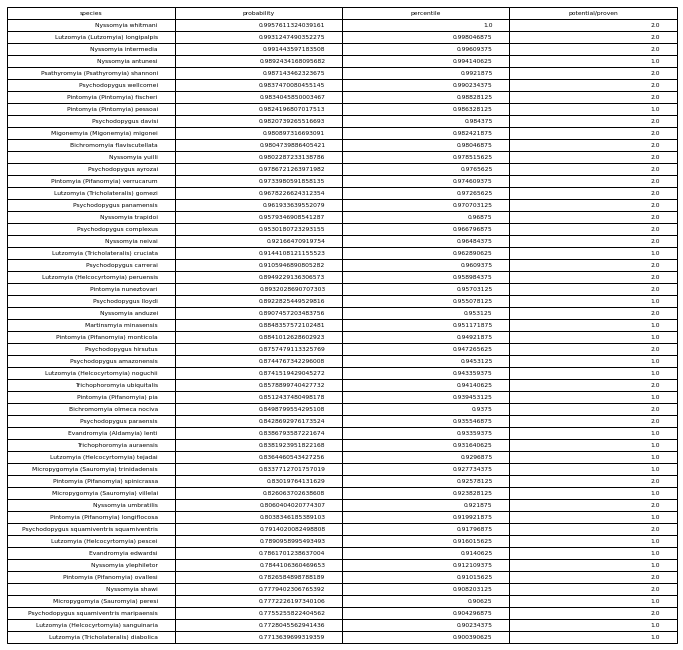

In [291]:
from matplotlib.backends.backend_pdf import PdfPages
fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=final_predictions.values,colLabels=final_predictions.columns,loc='center')

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("potential predictions.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [127]:
prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.mean(axis=1))
top_predictions = prediction_matrix
top_predictions['percentile'] = top_predictions.probability.rank(pct=True)
top_predictions = top_predictions[top_predictions['probability'] >= 0.5].reset_index(drop=True)
top_predictions = top_predictions[['species', 'probability', 'percentile']].reset_index(drop=True)
top_predictions = top_predictions.sort_values(by ='probability', ascending=False).reset_index(drop=True)
top_predictions = getstatus(top_predictions, 'leish')
top_predictions = top_predictions.fillna(0)
top_predictions.to_csv('test predictions.csv')

## distributions

In [277]:
density = prediction_matrix.set_index('species')
density = density.loc[final_predictions['species'].to_list()]

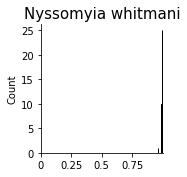

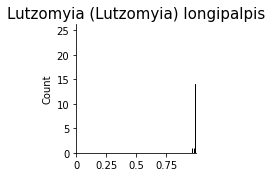

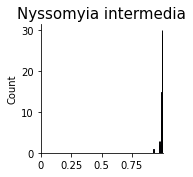

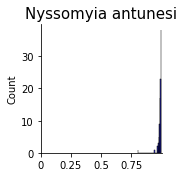

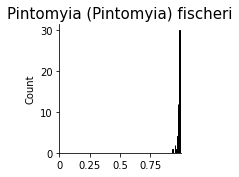

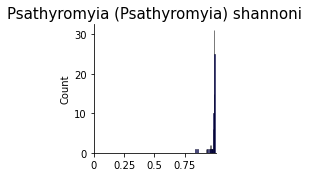

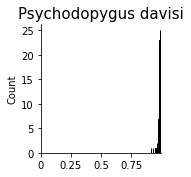

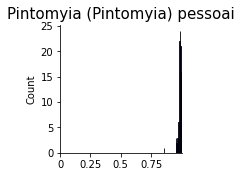

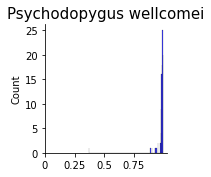

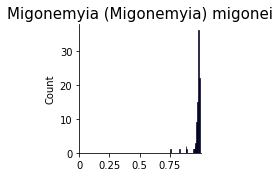

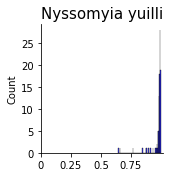

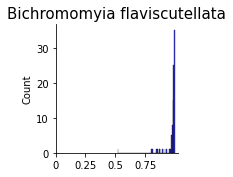

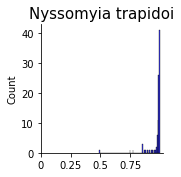

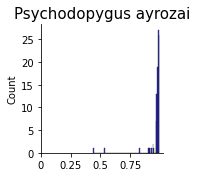

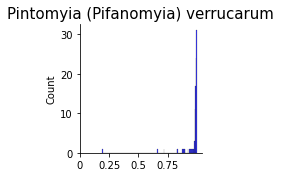

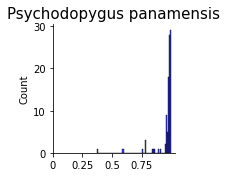

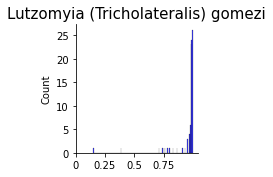

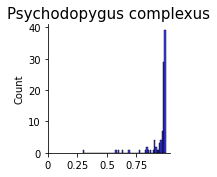

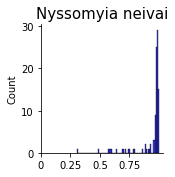

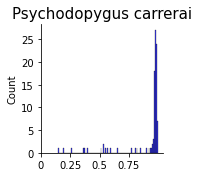

In [129]:
for x in range(20):
    sandfly = density.reset_index().loc[x, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    g = sns.displot(p, color='blue')
    g.fig.set_figwidth(2)
    g.fig.set_figheight(2)
    plt.title(sandfly, size=15)
    plt.xticks(ticks=[0, 0.25, 0.5, 0.75], labels=[0, 0.25, 0.5, 0.75])

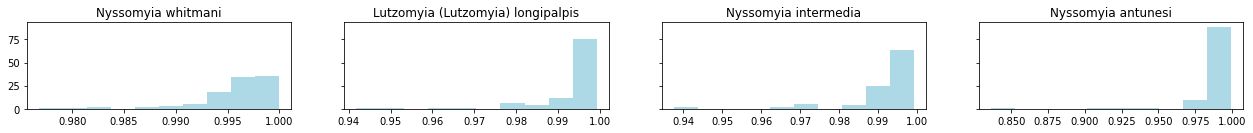

In [278]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

# left  = 0.125  # the left side of the subplots of the figure
# right = 0.9    # the right side of the subplots of the figure
# bottom = 0.1   # the bottom of the subplots of the figure
# top = 0.9      # the top of the subplots of the figure
# wspace = 0.2   # the amount of width reserved for blank space between subplots
# hspace = 0.2   # the amount of height reserved for white space between subplots

for x in range(4):
    sandfly = density.reset_index().loc[x, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('potential1.png', bbox_inches='tight')

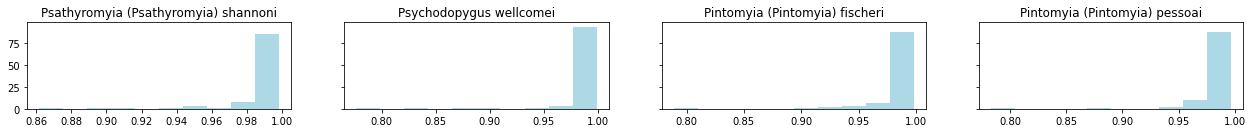

In [279]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+4, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('potential2.png', bbox_inches='tight')

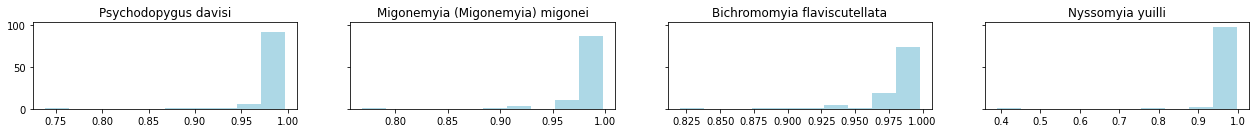

In [280]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+8, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('potential3.png', bbox_inches='tight')

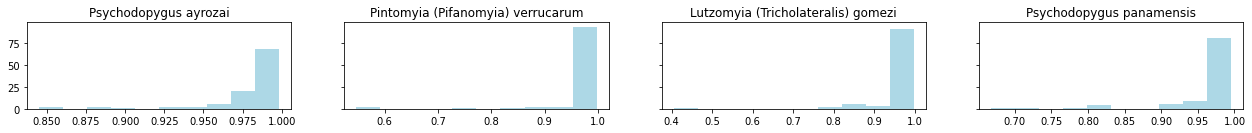

In [281]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+12, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('potential4.png', bbox_inches='tight')

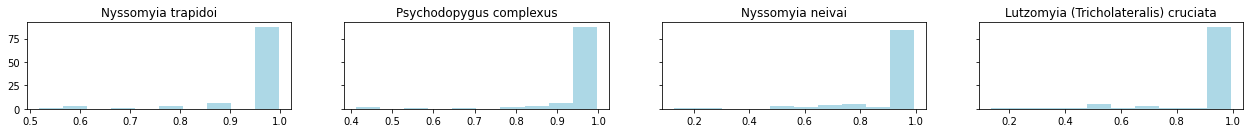

In [282]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+16, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('potential5.png', bbox_inches='tight')

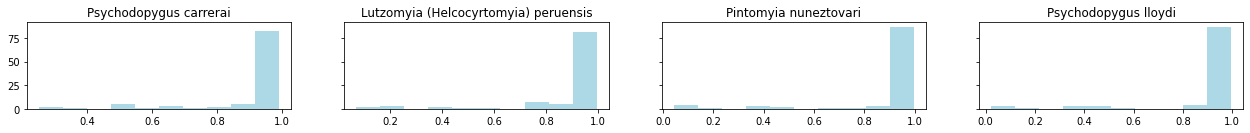

In [283]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+20, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('potential6.png', bbox_inches='tight')

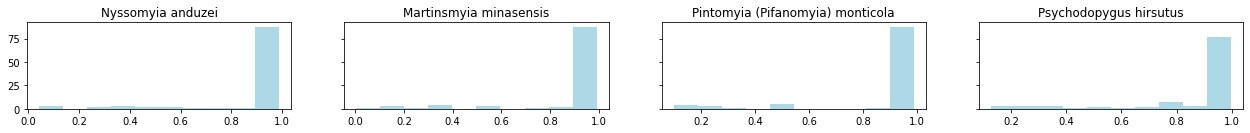

In [284]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+24, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('potential7.png', bbox_inches='tight')

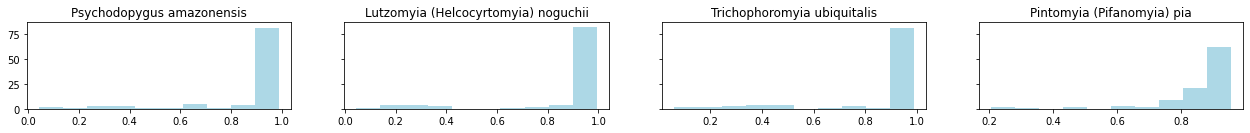

In [285]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+28, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('potential8.png', bbox_inches='tight')

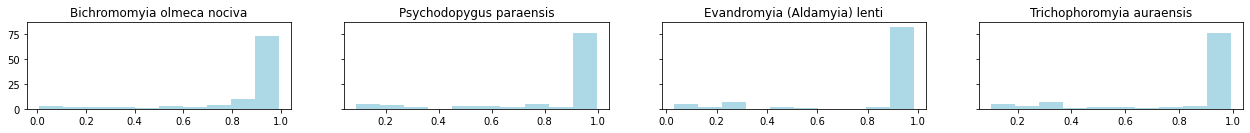

In [286]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+32, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('potential9.png', bbox_inches='tight')

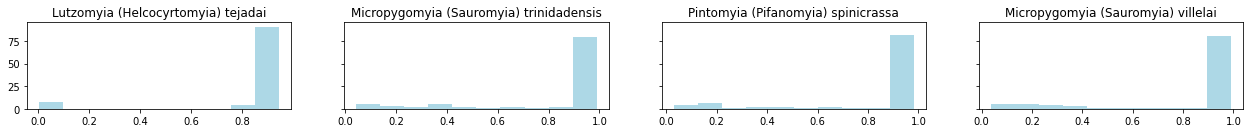

In [287]:
fig, axes = plt.subplots(1, 4, sharex='col', sharey='row', figsize = (9, 3))
# fig.tight_layout()
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.subplots_adjust(left=0.123, bottom=0.1, right=2, top=0.5, wspace=0.2, hspace=2)

for x in range(4):
    sandfly = density.reset_index().loc[x+36, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    axes[x].hist(p, color = 'lightblue')
    axes[x].set_title(sandfly)
plt.savefig('potential10.png', bbox_inches='tight')

## variable importance

In [289]:
importance = var_impt(models_list_potential).head(40).round(3)

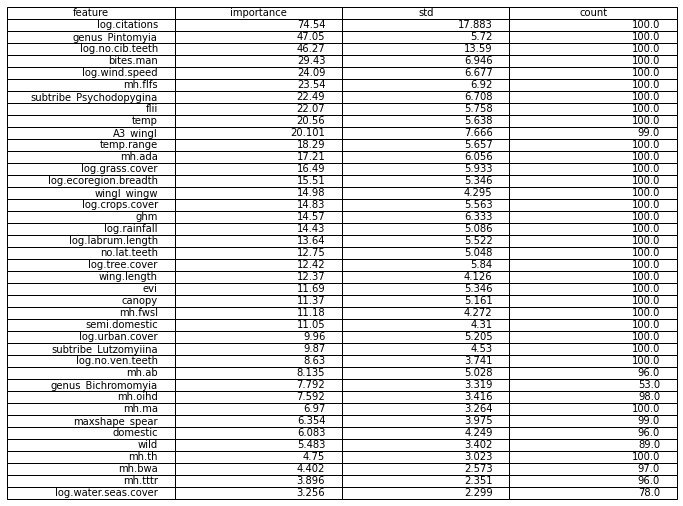

In [292]:
from matplotlib.backends.backend_pdf import PdfPages
fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=importance.values,colLabels=importance.columns,loc='center')

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("potential var impt.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [293]:
#get a dataframe with the feature, and lower and higher confidence bound for its importance
var_confidence = pd.DataFrame()
var_confidence['feature'] = 0
var_confidence['lower'] = 0
var_confidence['higher'] = 0

impten = fscore(models_list_potential)

for x in range(len(var_impt(models_list_potential))):
    feature = var_impt(models_list_potential)['feature'].to_list()[x]
    impt = var_impt(models_list_potential)['importance'].to_list()[x]
    var_confidence.loc[x, 'feature'] = feature
    var_confidence.loc[x, 'importance'] = impt
    var_confidence.loc[x, 'lower'] = getconf_interval_var(impten[impten['feature'] == feature]['importance'])[0]
    var_confidence.loc[x, 'higher'] = getconf_interval_var(impten[impten['feature'] == feature]['importance'])[1]

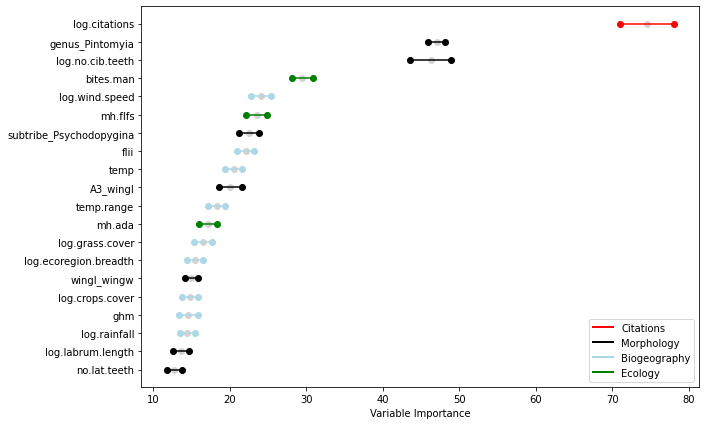

In [296]:
# plot the importances with their confidence intervals
from matplotlib.lines import Line2D
x = var_confidence.head(20)['feature'].to_list()
y = var_confidence.head(20)['importance'].to_list()
lower = var_confidence['lower'].head(20)
higher = var_confidence['higher'].head(20)

color_list = ['red', 'black', 'black', 'green', 'lightblue', 'green', 'black', 'lightblue', 'lightblue', 'black',
              'lightblue', 'green', 'lightblue', 'lightblue', 'black', 'lightblue', 'lightblue', 'lightblue', 'black', 'black']


plt.scatter(y, x, color = 'lightgrey')
#using https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
for lower,upper,y in zip(var_confidence['lower'].head(20), var_confidence['higher'].head(20), range(len(var_confidence))):
    plt.plot((lower,upper),(y,y),'bo-',color=color_list[y])

plt.yticks(range(len(var_confidence.head(20))), list(var_confidence['feature'].head(20)))

# plt.errorbar(y, x, fmt="o")
plt.rcParams["figure.figsize"] = (10,7)
plt.xlabel('Variable Importance')
plt.gca().invert_yaxis()

#legend
custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='lightblue', lw=2),
                Line2D([0], [0], color='green', lw=2)]
plt.legend(custom_lines, ['Citations', 'Morphology', 'Biogeography', 'Ecology'], loc='lower right')

# plt.show()

In [297]:
data = original_clean
X, y = data.iloc[:,:-1], data.iloc[:,-1]

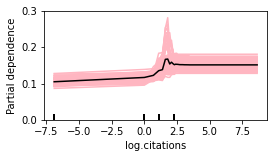

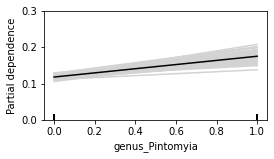

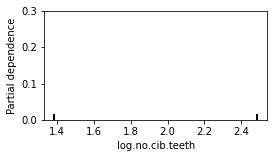

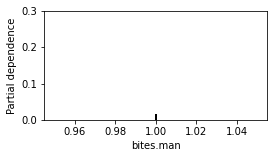

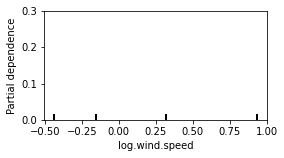

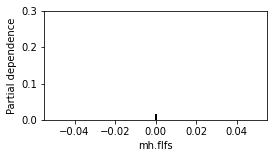

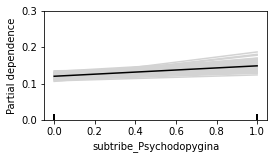

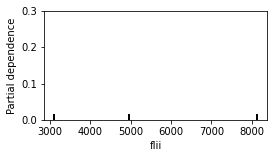

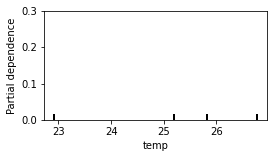

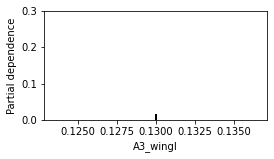

In [306]:
# fig = plt.figure()
# ax = plt.subplot(111)
model_type = models_list_potential
color_list = ['lightpink', 'lightgrey', 'lightgrey', 'green', 'lightblue', 'green', 'lightgrey', 'lightblue', 'lightblue', 'lightgrey',
              'lightblue', 'green', 'lightblue', 'lightblue', 'lightgrey', 'lightblue', 'lightblue', 'lightblue', 'lightgrey', 'lightgrey']


for a in range(10):
    fig = plt.figure()
    ax = plt.subplot(111)

    variable = importance.loc[a, 'feature']
    color = color_list[a]

    model0_plot = plot_partial_dependence(model_type[0], X, [variable], ax=ax,  line_kw={"color": color})
    for x in range(1, 100):
        model_plot = plot_partial_dependence(model_type[x], X, [variable], ax=model0_plot.axes_,  line_kw={"color": color})

    plt.ylim((0.0,0.3))

    #get average line
    ax = plt.gca()
    line = ax.lines[0]
    x_array = line.get_xdata()

    y_array = ax.lines[0].get_ydata()
    for i in range(1, 100):
        y_array += ax.lines[i].get_ydata()
    y_array = y_array/100
    fig.set_size_inches(4, 2)
    plt.plot(x_array, y_array, color = 'black')

# #histogram behind
# ax2 = ax.twinx()
# df_var = og['citations'].to_list()
# histogram = plt.hist(df_var, range=(0, 1), color = 'lightgrey', bins = 5, alpha = 0.4)

(0.0, 1.0)

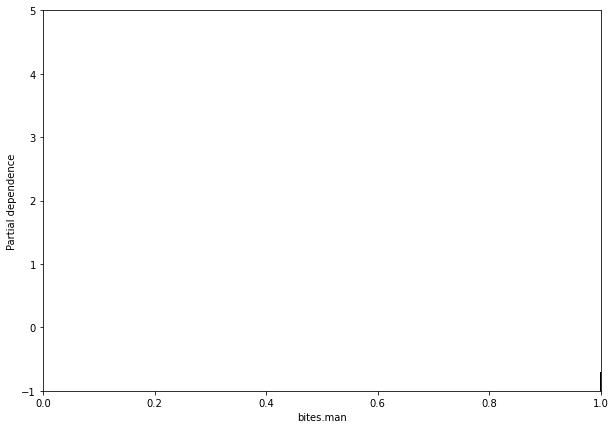

In [311]:
fig = plt.figure()
ax = plt.subplot(111)

variable = 'bites.man'
color = 'lightgreen'

model0_plot = plot_partial_dependence(model_type[0], X, [variable], ax=ax,  line_kw={"color": color})
for x in range(1, 10):
    model_plot = plot_partial_dependence(model_type[x], X, [variable], ax=model0_plot.axes_,  line_kw={"color": color})

plt.ylim((-1,5))
plt.xlim((0,1))

# #get average line
# ax = plt.gca()
# line = ax.lines[0]
# x_array = line.get_xdata()

# y_array = ax.lines[0].get_ydata()
# for i in range(1, 100):
#     y_array += ax.lines[i].get_ydata()
# y_array = y_array/100
# fig.set_size_inches(4, 2)
# plt.plot(x_array, y_array, color = 'black')

In [ ]:
#change to omit nans = play around with this

In [333]:
partial_dependence(model_type[0], X, ['temp'])

(array([[0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0.12178229, 0.12178229, 0.12178229,
         0.12178229, 0.12178229, 0

In [336]:
X['bites.man'].to_list()

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.0,
 0.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.0,
 nan,
 nan,
 1.0,
 1.0,
 nan,
 nan,
 nan,
 1.0,
 1.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.0,
 nan,
 nan,
 nan,
 nan,
 1.0,
 1.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.0,
 nan

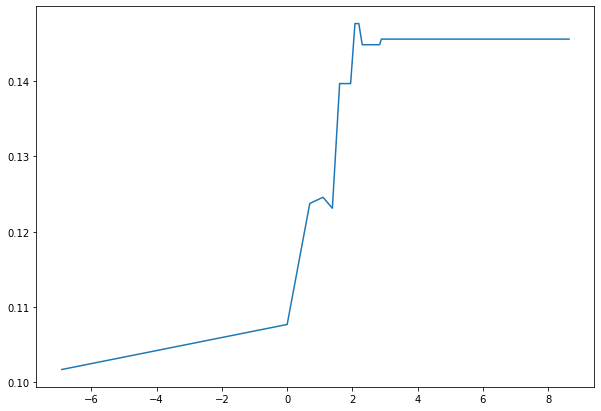

In [322]:
plt.plot(partial_dependence(model_type[0], X, ['log.citations'])[1][0], partial_dependence(model_type[0], X, ['log.citations'])[0][0])

In [332]:
%pip install pdpbox

  Using cached PDPbox-0.2.1-py3-none-any.whl
  Using cached matplotlib-3.1.1.tar.gz (37.8 MB)
  Running setup.py clean for matplotlib
Failed to build matplotlib
    Running setup.py install for matplotlib: started
    Running setup.py install for matplotlib: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\GarlicSauce\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\GarlicSauce\\AppData\\Local\\Temp\\pip-install-4t1qz0nj\\matplotlib_1b88f1c71eb7414bb59b1673d1310887\\setup.py'"'"'; __file__='"'"'C:\\Users\\GarlicSauce\\AppData\\Local\\Temp\\pip-install-4t1qz0nj\\matplotlib_1b88f1c71eb7414bb59b1673d1310887\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\GarlicSauce\AppData\Local\Temp\pip-wheel-5wwixot6'
       cwd: C:\Users\GarlicSauce\AppData\Local\Temp\pip-install-4t1qz0nj\matplotlib_1b88f1c71eb7414bb59b1673d1310887\
  Complete output (499 lines):
  Edit setup.cfg to change the build options
  
  BUILDING MATPLOTLIB
    

  copying lib\matplotlib\cbook\__init__.py -> build\lib.win-amd64-3.8\matplotlib\cbook
  creating build\lib.win-amd64-3.8\matplotlib\compat
  copying lib\matplotlib\compat\subprocess.py -> build\lib.win-amd64-3.8\matplotlib\compat
  copying lib\matplotlib\compat\__init__.py -> build\lib.win-amd64-3.8\matplotlib\compat
  creating build\lib.win-amd64-3.8\matplotlib\projections
  copying lib\matplotlib\projections\geo.py -> build\lib.win-amd64-3.8\matplotlib\projections
  copying lib\matplotlib\projections\polar.py -> build\lib.win-amd64-3.8\matplotlib\projections
  copying lib\matplotlib\projections\__init__.py -> build\lib.win-amd64-3.8\matplotlib\projections
  creating build\lib.win-amd64-3.8\matplotlib\sphinxext
  copying lib\matplotlib\sphinxext\mathmpl.py -> build\lib.win-amd64-3.8\matplotlib\sphinxext
  copying lib\matplotlib\sphinxext\plot_directive.py -> build\lib.win-amd64-3.8\matplotlib\sphinxext
  copying lib\matplotlib\sphinxext\__init__.py -> build\lib.win-amd64-3.8\matplotl

  copying lib\matplotlib\mpl-data\fonts\pdfcorefonts\Helvetica-BoldOblique.afm -> build\lib.win-amd64-3.8\matplotlib\mpl-data\fonts\pdfcorefonts
  copying lib\matplotlib\mpl-data\fonts\afm\phvb8a.afm -> build\lib.win-amd64-3.8\matplotlib\mpl-data\fonts\afm
  copying lib\matplotlib\mpl-data\images\zoom_to_rect_large.gif -> build\lib.win-amd64-3.8\matplotlib\mpl-data\images
  copying lib\matplotlib\mpl-data\fonts\afm\phvbo8an.afm -> build\lib.win-amd64-3.8\matplotlib\mpl-data\fonts\afm
  copying lib\matplotlib\mpl-data\fonts\ttf\STIXGeneralItalic.ttf -> build\lib.win-amd64-3.8\matplotlib\mpl-data\fonts\ttf
  copying lib\matplotlib\mpl-data\images\home_large.gif -> build\lib.win-amd64-3.8\matplotlib\mpl-data\images
  copying lib\matplotlib\mpl-data\fonts\afm\pagdo8a.afm -> build\lib.win-amd64-3.8\matplotlib\mpl-data\fonts\afm
  copying lib\matplotlib\mpl-data\fonts\afm\cmex10.afm -> build\lib.win-amd64-3.8\matplotlib\mpl-data\fonts\afm
  copying lib\matplotlib\mpl-data\fonts\afm\pplr8a.af

In [328]:
import pdpbox
from pdpbox import pdp, get_dataset, info_plots

pdp_goals = pdp.pdp_isolate(model=model_type[0], dataset=X, model_features=['bites.man'], feature='Goal Scored')

# plot it
pdp.pdp_plot(pdp_goals)
plt.show()

ModuleNotFoundError: No module named 'pdpbox'